
# F1 Race, Driver, and Team Analytics


In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [235]:
from google.colab import files
uploaded = files.upload()

Saving F1_flat_final.xlsx to F1_flat_final (4).xlsx


In [236]:
df = pd.read_excel("F1_flat_final.xlsx")


## 1. Load Dataset

In [237]:
file_path = "/content/F1_flat_final.xlsx"

df = pd.read_excel(file_path)
print(df.shape)
df.head()


(5922, 39)


season  round              race_name           driver   constructor  laps  \
0    2018      1  Australian Grand Prix  Kevin Magnussen  Haas F1 Team    22   
1    2018      1  Australian Grand Prix  Marcus Ericsson        Sauber     5   
2    2018      1  Australian Grand Prix     Pierre Gasly    Toro Rosso    13   
3    2018      1  Australian Grand Prix  Romain Grosjean  Haas F1 Team    24   
4    2018      4  Azerbaijan Grand Prix  Nico Hülkenberg       Renault    10   

   totalpitstops  stint  stint_length  pit_lap  ...  year month  day  \
0              1    1.0            21     22.0  ...  2018     3   25   
1              0    1.0             5      NaN  ...  2018     3   25   
2              0    1.0            13      NaN  ...  2018     3   25   
3              1    1.0            23     24.0  ...  2018     3   25   
4              0    1.0            10      NaN  ...  2018     4   29   

   is_dnf_end_of_pit expected_stints is_final_stint is_pit_stop  points  \
0               True               2          False           1       0   
1              False               1           True           0       0   
2              False               1           True           0       0   
3               True               2          False           1       0   
4              False               1           True           0       0   

        race_winner   season_winner  
0  Sebastian Vettel  Lewis Hamilton  
1  Sebastian Vettel  Lewis Hamilton  
2  Sebastian Vettel  Lewis Hamilton  
3  Sebastian Vettel  Lewis Hamilton  
4    Lewis Hamilton  Lewis Hamilton  

[5 rows x 39 columns]

## 2. Quick Data Overview

In [238]:

print("Columns:", df.columns.tolist())
print("\nBasic info:")
df.info()


Columns: ['season', 'round', 'race_name', 'driver', 'constructor', 'laps', 'totalpitstops', 'stint', 'stint_length', 'pit_lap', 'pit_time', 'circuit', 'position', 'avgpitstoptime', 'time_of_race', 'location', 'country', 'air_temp_c', 'track_temp_c', 'humidity_%', 'wind_speed_kmh', 'lap_time_variation', 'tire_usage_aggression', 'fast_lap_attempts', 'position_changes', 'driver_aggression_score', 'abbreviation', 'tire_compound', 'tire_compound_code', 'year', 'month', 'day', 'is_dnf_end_of_pit', 'expected_stints', 'is_final_stint', 'is_pit_stop', 'points', 'race_winner', 'season_winner']

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5922 entries, 0 to 5921
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   season                   5922 non-null   int64  
 1   round                    5922 non-null   int64  
 2   race_name                5922 non-null   object 
 3   driver        

In [239]:
# Basic numeric summary for a few important columns
df[["season", "round", "laps", "totalpitstops", "stint", "stint_length",
    "pit_lap", "pit_time", "position", "points"]].describe()


season        round         laps  totalpitstops        stint  \
count  5922.000000  5922.000000  5922.000000    5922.000000  5921.000000   
mean   2021.716819    10.856130    58.230834       2.172915     2.084783   
std       1.728298     6.195506    11.404860       1.123135     1.084086   
min    2018.000000     1.000000     1.000000       0.000000     1.000000   
25%    2020.000000     6.000000    52.000000       1.000000     1.000000   
50%    2022.000000    11.000000    57.000000       2.000000     2.000000   
75%    2023.000000    16.000000    66.000000       3.000000     3.000000   
max    2024.000000    24.000000    87.000000       7.000000     8.000000   

       stint_length      pit_lap     pit_time     position       points  
count   5922.000000  3843.000000  3843.000000  5922.000000  5922.000000  
mean      20.220871    26.172001   138.833472     9.726613     5.554880  
std       12.163756    15.537476   434.267862     5.394368     7.362896  
min        1.000000     1.000000    13.973000     1.000000     0.000000  
25%       12.000000    13.000000    22.128500     5.000000     0.000000  
50%       19.000000    26.000000    24.029000    10.000000     1.000000  
75%       28.000000    37.000000    29.052500    14.000000    10.000000  
max       77.000000    78.000000  3069.017000    20.000000    26.000000

number of races attended

In [240]:
constructor_races = df.groupby("constructor") \
    .agg(races_attended=("race_name", "nunique")) \
    .reset_index()

constructor_races.sort_values("races_attended", ascending=False)

constructor  races_attended
6     Haas F1 Team              35
0       Alfa Romeo              34
4          Ferrari              34
7          McLaren              34
11        Red Bull              34
8         Mercedes              34
15        Williams              33
1       AlphaTauri              31
2   Alpine F1 Team              28
3     Aston Martin              28
10    Racing Point              27
12         Renault              25
13          Sauber              23
9       RB F1 Team              23
14      Toro Rosso              18
5      Force India               3

In [241]:
constructor_races_season = df.groupby(["season", "constructor"]) \
    .agg(races_attended=("race_name", "nunique")) \
    .reset_index()

constructor_races_season

season   constructor  races_attended
0     2018       Ferrari               2
1     2018   Force India               3
2     2018  Haas F1 Team               3
3     2018       McLaren               1
4     2018      Mercedes               3
..     ...           ...             ...
65    2024      Mercedes              22
66    2024    RB F1 Team              23
67    2024      Red Bull              22
68    2024        Sauber              22
69    2024      Williams              22

[70 rows x 3 columns]

## 3. Build Driver–Race Level Table

In [242]:
# Define a mask for realistic pit stop times (in seconds)
valid_pit_mask = (df["pit_time"] >= 15) & (df["pit_time"] <= 40)

# Driver–race level aggregation
driver_race = df.groupby(
    ["season", "race_name", "driver", "constructor"],
    as_index=False
).agg(
    total_pit_time=("pit_time", lambda x: x[valid_pit_mask.loc[x.index]].sum()),
    n_pitstops=("pit_time", lambda x: valid_pit_mask.loc[x.index].sum()),
    n_stints=("stint", "max"),
    points=("points", "max"),
    position=("position", "max"),
    laps_completed=("laps", "max"),
    avg_pit_time=("pit_time", lambda x: x[valid_pit_mask.loc[x.index]].mean()),
    driver_aggr=("driver_aggression_score", "max"),
    pos_changes=("position_changes", "max")
)

driver_race.head()


season              race_name           driver   constructor  \
0    2018  Australian Grand Prix  Kevin Magnussen  Haas F1 Team   
1    2018  Australian Grand Prix  Marcus Ericsson        Sauber   
2    2018  Australian Grand Prix     Pierre Gasly    Toro Rosso   
3    2018  Australian Grand Prix  Romain Grosjean  Haas F1 Team   
4    2018    Austrian Grand Prix  Brendon Hartley    Toro Rosso   

   total_pit_time  n_pitstops  n_stints  points  position  laps_completed  \
0          21.983           1       1.0       0        17              22   
1           0.000           0       1.0       0        19               5   
2           0.000           0       1.0       0        18              13   
3          23.054           1       1.0       0        16              24   
4           0.000           0       1.0       0        17              54   

   avg_pit_time  driver_aggr  pos_changes  
0        21.983      6.80083     0.695652  
1           NaN          NaN     0.782609  
2           NaN          NaN     0.739130  
3        23.054      6.63518     0.652174  
4           NaN          NaN     0.695652

## 4. Race-Level Analytics

In [243]:
race_level = driver_race.groupby(
    ["season", "race_name"],
    as_index=False
).agg(
    drivers_started=("driver", "nunique"),
    avg_pitstops=("n_pitstops", "mean"),
    median_pitstops=("n_pitstops", "median"),
    pct_one_stop=("n_pitstops", lambda x: (x == 1).mean() * 100),
    pct_two_or_more_stops=("n_pitstops", lambda x: (x >= 2).mean() * 100),
    avg_pit_time=("avg_pit_time", "mean"),
    race_laps=("laps_completed", "max"),
    avg_driver_aggr=("driver_aggr", "mean"),
    avg_pos_change=("pos_changes", "mean")
)

race_level.sort_values(["season", "race_name"]).head(10)


season                 race_name  drivers_started  avg_pitstops  \
0    2018     Australian Grand Prix                4      0.500000   
1    2018       Austrian Grand Prix                3      0.000000   
2    2018     Azerbaijan Grand Prix                1      0.000000   
3    2018        British Grand Prix                1      1.000000   
4    2018         French Grand Prix                1      0.000000   
5    2018         German Grand Prix                1      0.000000   
6    2018      Hungarian Grand Prix                1      0.000000   
7    2018        Mexican Grand Prix               15      1.666667   
8    2018  United States Grand Prix               14      1.071429   
9    2019     Australian Grand Prix               16      1.062500   

   median_pitstops  pct_one_stop  pct_two_or_more_stops  avg_pit_time  \
0              0.5     50.000000               0.000000     22.518500   
1              0.0      0.000000               0.000000           NaN   
2              0.0      0.000000               0.000000           NaN   
3              1.0    100.000000               0.000000     27.865000   
4              0.0      0.000000               0.000000           NaN   
5              0.0      0.000000               0.000000           NaN   
6              0.0      0.000000               0.000000           NaN   
7              2.0     40.000000              60.000000     23.506578   
8              1.0     78.571429              14.285714     24.513231   
9              1.0     93.750000               6.250000     22.344812   

   race_laps  avg_driver_aggr  avg_pos_change  
0         24         6.718005        0.717391  
1         54              NaN        0.768116  
2         10              NaN        0.739130  
3         18         5.929826        0.782609  
4         27              NaN        0.739130  
5         27              NaN        0.826087  
6          5              NaN        0.782609  
7         71         6.556748        0.342029  
8         56         6.383628        0.341615  
9         58         6.706492        0.326087

### 4.1 Season-Level Strategy Summary

In [244]:

season_strategy = race_level.groupby("season").agg(
    races=("race_name", "nunique"),
    avg_pitstops=("avg_pitstops", "mean"),
    avg_pct_one_stop=("pct_one_stop", "mean"),
    avg_pct_two_or_more=("pct_two_or_more_stops", "mean"),
    avg_driver_aggr=("avg_driver_aggr", "mean"),
    avg_pos_change=("avg_pos_change", "mean")
).reset_index()

season_strategy.round(2)


season  races  avg_pitstops  avg_pct_one_stop  avg_pct_two_or_more  \
0    2018      9          0.47             29.84                 8.25   
1    2019     19          1.47             55.55                38.57   
2    2020     16          1.71             39.39                58.23   
3    2021     19          1.55             49.31                46.31   
4    2022     19          1.69             42.39                54.16   
5    2023     21          1.83             34.46                60.43   
6    2024     24          1.63             40.00                54.07   

   avg_driver_aggr  avg_pos_change  
0             6.40            0.67  
1             6.27            0.39  
2            19.01            0.40  
3            29.87            0.38  
4            15.86            0.37  
5            19.21            0.39  
6            27.23            0.38

Average pit stops per driver per race:

2018: ~0.47 (low-stop races)

2019–2024: 1.5–1.8 stops/driver

2023 peaks at 1.83 stops/driver

### 4.2 Plot: Average Pit Stops per Driver per Race (by Season)

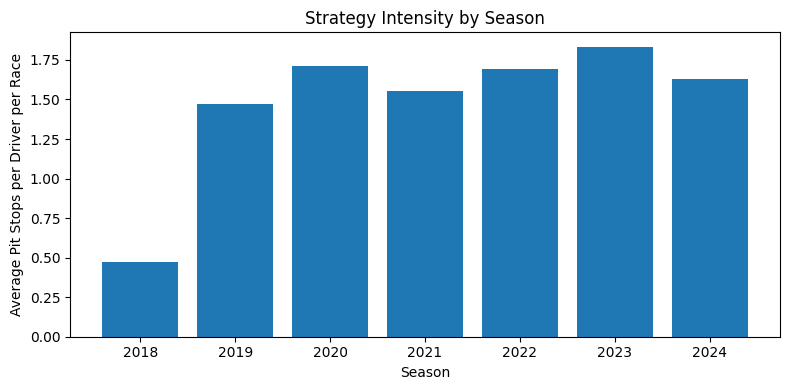

In [245]:

plt.figure(figsize=(8, 4))
plt.bar(season_strategy["season"], season_strategy["avg_pitstops"])
plt.xlabel("Season")
plt.ylabel("Average Pit Stops per Driver per Race")
plt.title("Strategy Intensity by Season")
plt.tight_layout()
plt.show()


### 4.3 Plot: Average % of Drivers with ≥ 2 Stops (by Season)

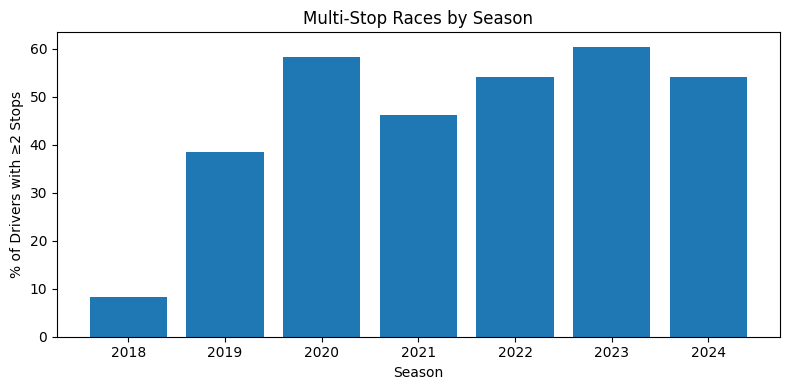

In [246]:

plt.figure(figsize=(8, 4))
plt.bar(season_strategy["season"], season_strategy["avg_pct_two_or_more"])
plt.xlabel("Season")
plt.ylabel("% of Drivers with ≥2 Stops")
plt.title("Multi-Stop Races by Season")
plt.tight_layout()
plt.show()


shows that 2020+ is a proper tyre-management era: more than half the grid often goes for 2+ stops.

### 4.4 Top 10 Most Multi-Stop Races

In [247]:
top_multi_stop_races = race_level.sort_values(
    "pct_two_or_more_stops", ascending=False
).head(10)[
    ["season", "race_name", "avg_pitstops", "pct_two_or_more_stops", "avg_pit_time", "race_laps"]
]

top_multi_stop_races


season              race_name  avg_pitstops  pct_two_or_more_stops  \
18     2019      German Grand Prix      4.230769                  100.0   
55     2021  Portuguese Grand Prix      3.157895                  100.0   
37     2020  Portuguese Grand Prix      2.000000                  100.0   
84     2023    Austrian Grand Prix      3.210526                  100.0   
70     2022       Dutch Grand Prix      2.894737                  100.0   
67     2022     Belgian Grand Prix      2.111111                  100.0   
124    2024     Spanish Grand Prix      2.100000                  100.0   
98     2023       Qatar Grand Prix      3.000000                  100.0   
101    2023     Spanish Grand Prix      2.150000                  100.0   
105    2024    Austrian Grand Prix      2.250000                  100.0   

     avg_pit_time  race_laps  
18      21.587481         64  
55      23.739307         66  
37      36.898500         51  
84      21.766969         71  
70      20.317272         72  
67      23.815222         44  
124     22.651325         66  
98      29.288690         57  
101     23.013917         66  
105     22.569475         71

season              race_name  avg_pitstops  pct_two_or_more_stops  \
18     2019      German Grand Prix      4.230769                  100.0   
55     2021  Portuguese Grand Prix      3.157895                  100.0   
37     2020  Portuguese Grand Prix      2.000000                  100.0   
84     2023    Austrian Grand Prix      3.210526                  100.0   
70     2022       Dutch Grand Prix      2.894737                  100.0   
67     2022     Belgian Grand Prix      2.111111                  100.0   
124    2024     Spanish Grand Prix      2.100000                  100.0   
98     2023       Qatar Grand Prix      3.000000                  100.0   
101    2023     Spanish Grand Prix      2.150000                  100.0   
105    2024    Austrian Grand Prix      2.250000                  100.0   

     avg_pit_time  race_laps  
18      21.587481         64  
55      23.739307         66  
37      36.898500         51  
84      21.766969         71  
70      20.317272         72  
67      23.815222         44  
124     22.651325         66  
98      29.288690         57  
101     23.013917         66  
105     22.569475         71

### 4.5 Aggression trend by season

In [248]:
mean_aggr_by_season = race_level.groupby("season")["avg_driver_aggr"].mean().reset_index()
mean_aggr_by_season

season  avg_driver_aggr
0    2018         6.397052
1    2019         6.272898
2    2020        19.013939
3    2021        29.868115
4    2022        15.864255
5    2023        19.209429
6    2024        27.229932

season  avg_driver_aggr
0    2018         6.397052
1    2019         6.272898
2    2020        19.013939
3    2021        29.868115
4    2022        15.864255
5    2023        19.209429
6    2024        27.229932

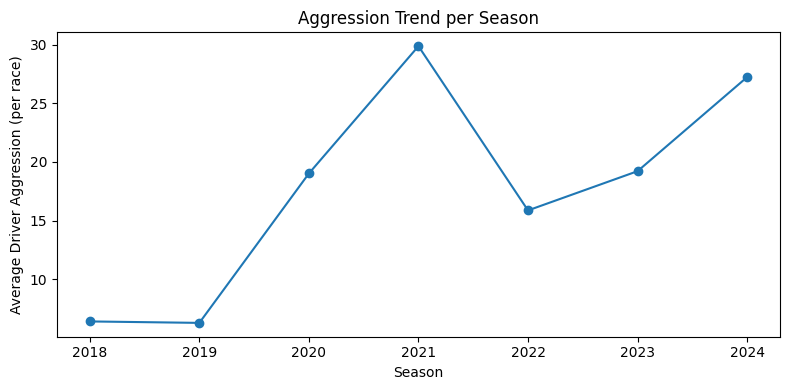

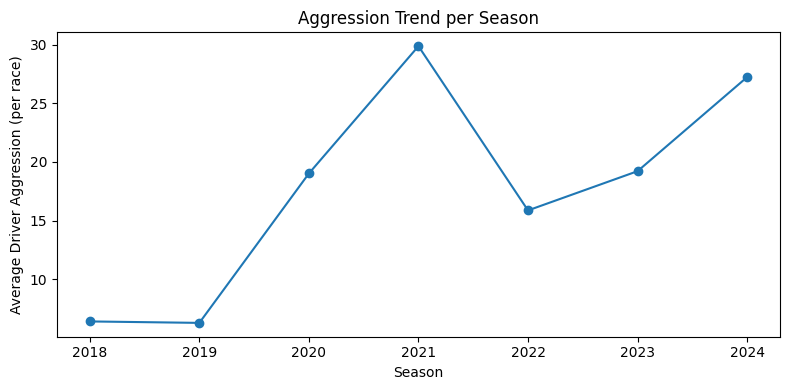

In [249]:
plt.figure(figsize=(8, 4))
plt.plot(mean_aggr_by_season["season"],
         mean_aggr_by_season["avg_driver_aggr"],
         marker="o")

plt.xlabel("Season")
plt.ylabel("Average Driver Aggression (per race)")
plt.title("Aggression Trend per Season")
plt.tight_layout()
plt.show()

### 4.6 Correlation: Strategy vs Aggression

In [250]:
corr_matrix = race_level[["avg_pitstops", "avg_driver_aggr"]].corr()
print(corr_matrix)

                 avg_pitstops  avg_driver_aggr
avg_pitstops         1.000000        -0.210981
avg_driver_aggr     -0.210981         1.000000
                 avg_pitstops  avg_driver_aggr
avg_pitstops         1.000000        -0.210981
avg_driver_aggr     -0.210981         1.000000


(slightly negative relation) Races with more stops are not necessarily more aggressive

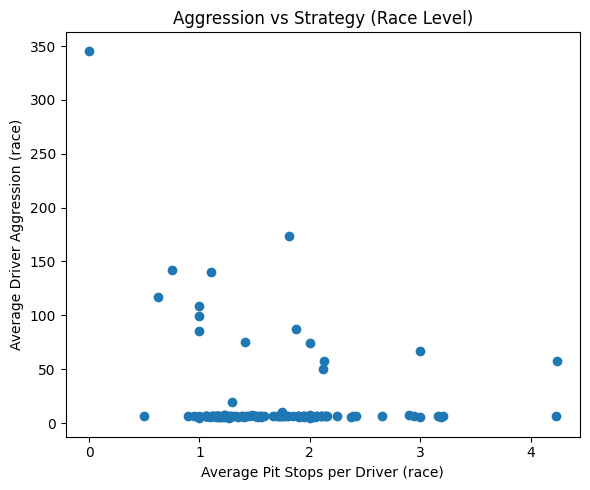

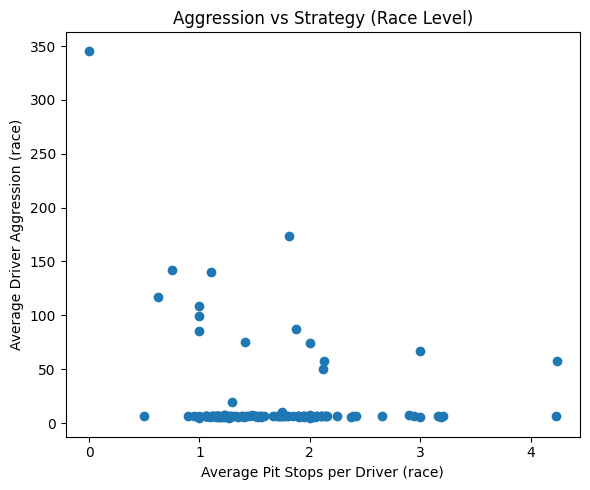

In [251]:
plt.figure(figsize=(6, 5))
plt.scatter(race_level["avg_pitstops"], race_level["avg_driver_aggr"])

plt.xlabel("Average Pit Stops per Driver (race)")
plt.ylabel("Average Driver Aggression (race)")
plt.title("Aggression vs Strategy (Race Level)")
plt.tight_layout()
plt.show()

## 5. Team-Level Analytics

In [252]:
team_season = driver_race.groupby(
    ["season", "constructor"],
    as_index=False
).agg(
    races_entered=("race_name", "nunique"),
    total_points=("points", "sum"),
    avg_points=("points", "mean"),
    avg_finish=("position", "mean"),
    best_finish=("position", "min"),
    avg_pitstops=("n_pitstops", "mean"),
    avg_pit_time=("avg_pit_time", "mean"),
    avg_driver_aggr=("driver_aggr", "mean"),
    avg_pos_gain=("pos_changes", "mean")
)

team_season.head(100)


season   constructor  races_entered  total_points  avg_points  avg_finish  \
0     2018       Ferrari              2            70   17.500000    2.500000   
1     2018   Force India              3             4    0.800000   14.800000   
2     2018  Haas F1 Team              3             0    0.000000   16.800000   
3     2018       McLaren              1             0    0.000000   18.000000   
4     2018      Mercedes              3            47    9.400000    7.200000   
..     ...           ...            ...           ...         ...         ...   
65    2024      Mercedes             22           413    9.833333    6.023810   
66    2024    RB F1 Team             23            32    0.761905   13.023810   
67    2024      Red Bull             22           503   12.897436    4.897436   
68    2024        Sauber             22             4    0.093023   15.697674   
69    2024      Williams             22            17    0.447368   14.368421   

    best_finish  avg_pitstops  avg_pit_time  avg_driver_aggr  avg_pos_gain  
0             1      1.250000     23.099375         6.574176      0.065217  
1             8      1.000000     24.823250         6.366418      0.600000  
2            15      1.200000     22.845900         6.674618      0.686957  
3            18      0.000000           NaN              NaN      0.739130  
4             3      1.600000     23.112667         6.608910      0.269565  
..          ...           ...           ...              ...           ...  
65            1      1.714286     24.203549        17.619111      0.218427  
66            7      1.523810     24.116114        24.555723      0.522774  
67            1      1.820513     24.039265         9.711240      0.169454  
68            8      1.627907     24.789008         9.206256      0.639029  
69            7      1.763158     24.693556        16.596546      0.581236  

[70 rows x 11 columns]

season   constructor  races_entered  total_points  avg_points  avg_finish  \
0     2018       Ferrari              2            70   17.500000    2.500000   
1     2018   Force India              3             4    0.800000   14.800000   
2     2018  Haas F1 Team              3             0    0.000000   16.800000   
3     2018       McLaren              1             0    0.000000   18.000000   
4     2018      Mercedes              3            47    9.400000    7.200000   
..     ...           ...            ...           ...         ...         ...   
65    2024      Mercedes             22           413    9.833333    6.023810   
66    2024    RB F1 Team             23            32    0.761905   13.023810   
67    2024      Red Bull             22           503   12.897436    4.897436   
68    2024        Sauber             22             4    0.093023   15.697674   
69    2024      Williams             22            17    0.447368   14.368421   

    best_finish  avg_pitstops  avg_pit_time  avg_driver_aggr  avg_pos_gain  
0             1      1.250000     23.099375         6.574176      0.065217  
1             8      1.000000     24.823250         6.366418      0.600000  
2            15      1.200000     22.845900         6.674618      0.686957  
3            18      0.000000           NaN              NaN      0.739130  
4             3      1.600000     23.112667         6.608910      0.269565  
..          ...           ...           ...              ...           ...  
65            1      1.714286     24.203549        17.619111      0.218427  
66            7      1.523810     24.116114        24.555723      0.522774  
67            1      1.820513     24.039265         9.711240      0.169454  
68            8      1.627907     24.789008         9.206256      0.639029  
69            7      1.763158     24.693556        16.596546      0.581236  

[70 rows x 11 columns]

### 5.1 Overall Constructor Performance

In [253]:

constructor_overall = team_season.groupby("constructor", as_index=False).agg(
    seasons=("season", "nunique"),
    races=("races_entered", "sum"),
    total_points=("total_points", "sum"),
    avg_points=("avg_points", "mean"),
    avg_finish=("avg_finish", "mean"),
    best_finish=("best_finish", "min"),
    avg_pitstops=("avg_pitstops", "mean"),
    avg_pit_time=("avg_pit_time", "mean"),
    avg_driver_aggr=("avg_driver_aggr", "mean"),
    avg_pos_gain=("avg_pos_gain", "mean")
)

# Best constructors by points
constructor_overall.sort_values("total_points", ascending=False).head(10)


constructor  seasons  races  total_points  avg_points  avg_finish  \
11        Red Bull        7    116          2974   13.692366    5.393438   
8         Mercedes        7    116          2839   13.024325    4.866687   
4          Ferrari        7    115          2241   11.074128    5.833596   
7          McLaren        7    115          1518    5.756879    9.434195   
3     Aston Martin        4     82           452    2.956459   10.529024   
2   Alpine F1 Team        4     80           416    2.860678   10.959184   
12         Renault        3     35           276    4.324657   10.129255   
1       AlphaTauri        4     74           266    2.046043   11.654435   
10    Racing Point        2     33           255    4.841875    8.893125   
0       Alfa Romeo        5     92           115    0.712265   13.017081   

    best_finish  avg_pitstops  avg_pit_time  avg_driver_aggr  avg_pos_gain  
11            1      1.638777     24.146548        13.658142      0.191019  
8             1      1.692301     24.190777        15.098311      0.168117  
4             1      1.552404     24.301083        17.070496      0.210156  
7             1      1.408997     24.780644        19.350621      0.366704  
3             2      1.683741     24.701249        20.426800      0.414305  
2             1      1.560762     24.358262        18.491231      0.433008  
12            2      1.056878     25.203359        10.681902      0.396924  
1             1      1.699498     24.725074        21.484776      0.463236  
10            1      1.585625     25.476821        13.852290      0.343179  
0             5      1.647259     25.356762        18.473617      0.522482

constructor  seasons  races  total_points  avg_points  avg_finish  \
11        Red Bull        7    116          2974   13.692366    5.393438   
8         Mercedes        7    116          2839   13.024325    4.866687   
4          Ferrari        7    115          2241   11.074128    5.833596   
7          McLaren        7    115          1518    5.756879    9.434195   
3     Aston Martin        4     82           452    2.956459   10.529024   
2   Alpine F1 Team        4     80           416    2.860678   10.959184   
12         Renault        3     35           276    4.324657   10.129255   
1       AlphaTauri        4     74           266    2.046043   11.654435   
10    Racing Point        2     33           255    4.841875    8.893125   
0       Alfa Romeo        5     92           115    0.712265   13.017081   

    best_finish  avg_pitstops  avg_pit_time  avg_driver_aggr  avg_pos_gain  
11            1      1.638777     24.146548        13.658142      0.191019  
8             1      1.692301     24.190777        15.098311      0.168117  
4             1      1.552404     24.301083        17.070496      0.210156  
7             1      1.408997     24.780644        19.350621      0.366704  
3             2      1.683741     24.701249        20.426800      0.414305  
2             1      1.560762     24.358262        18.491231      0.433008  
12            2      1.056878     25.203359        10.681902      0.396924  
1             1      1.699498     24.725074        21.484776      0.463236  
10            1      1.585625     25.476821        13.852290      0.343179  
0             5      1.647259     25.356762        18.473617      0.522482

Red Bull wins on sheer points, Mercedes wins on consistency, Ferrari is fast but a bit more chaotic.

The lower/midfield teams (Williams, Haas, Alfa, AlphaTauri, etc.) tend to have high average position gains: they often start deep and move forward. Strategy + race craft is their survival tool.

### 5.2 Plot: Total Points by Constructor

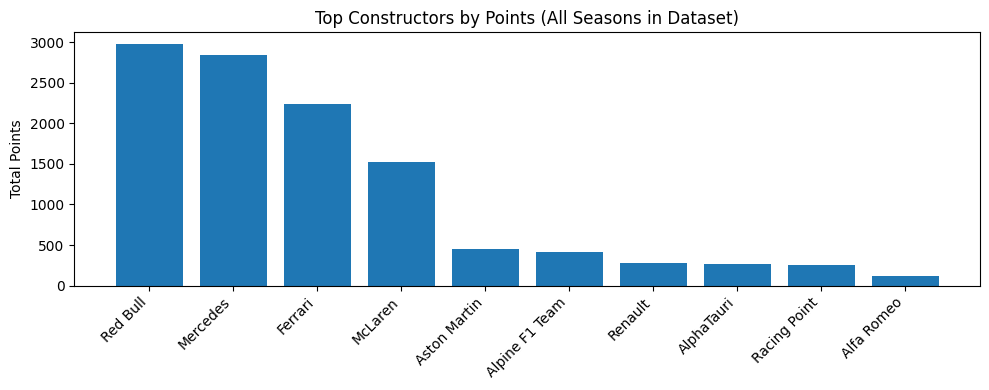

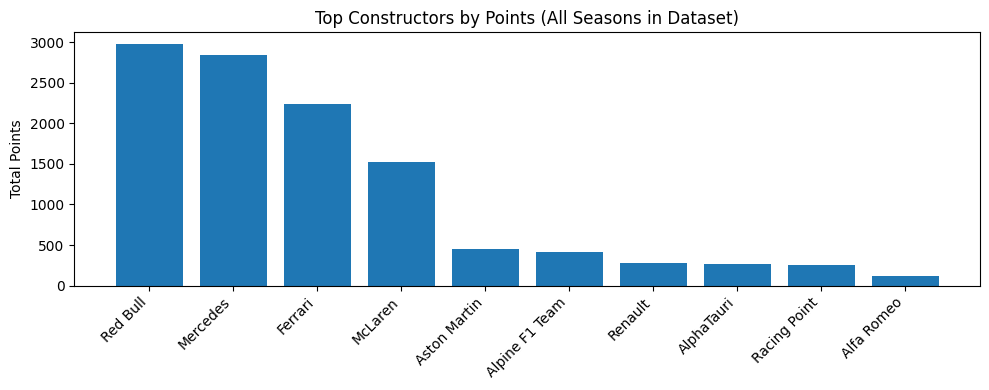

In [254]:
top_constructors = constructor_overall.sort_values("total_points", ascending=False).head(10)

plt.figure(figsize=(10, 4))
plt.bar(top_constructors["constructor"], top_constructors["total_points"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Points")
plt.title("Top Constructors by Points (All Seasons in Dataset)")
plt.tight_layout()
plt.show()


### 5.3 Constructors: Average Position Gain vs Average Finish

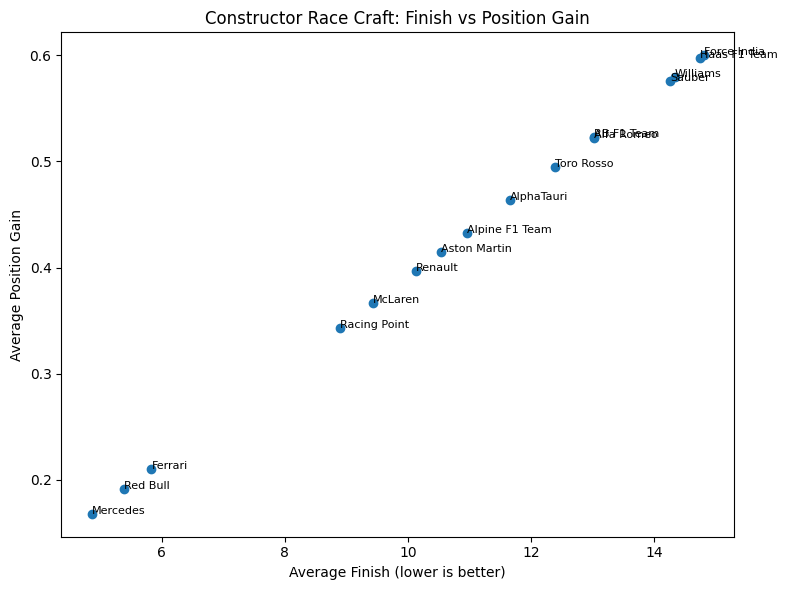

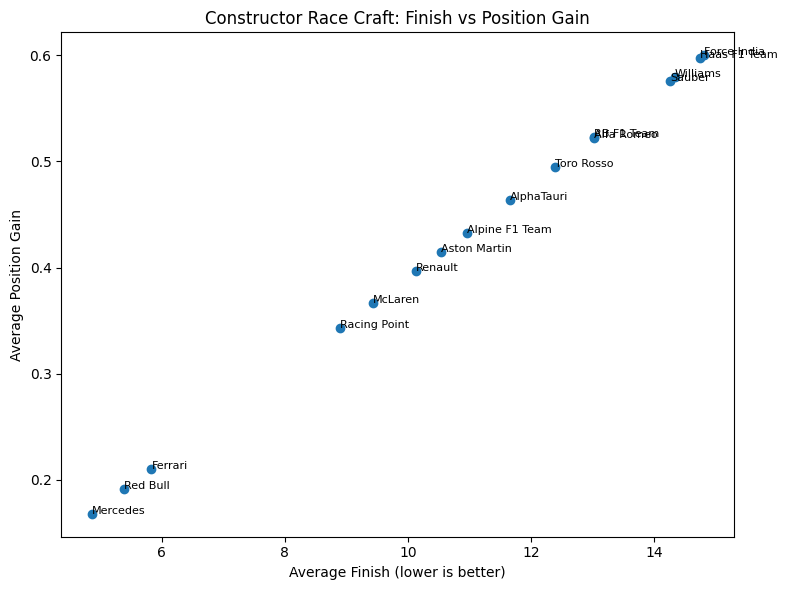

In [255]:
plt.figure(figsize=(8, 6))
plt.scatter(constructor_overall["avg_finish"], constructor_overall["avg_pos_gain"])

for _, row in constructor_overall.iterrows():
    plt.annotate(row["constructor"], (row["avg_finish"], row["avg_pos_gain"]), fontsize=8)

plt.xlabel("Average Finish (lower is better)")
plt.ylabel("Average Position Gain")
plt.title("Constructor Race Craft: Finish vs Position Gain")
plt.tight_layout()
plt.show()


## 6. Driver-Level Analytics

In [256]:

driver_career = driver_race.groupby(["driver", "constructor"], as_index=False).agg(
    seasons=("season", "nunique"),
    races=("race_name", "nunique"),
    total_points=("points", "sum"),
    avg_points=("points", "mean"),
    avg_finish=("position", "mean"),
    best_finish=("position", "min"),
    podiums=("position", lambda x: (x <= 3).sum()),
    wins=("position", lambda x: (x == 1).sum()),
    avg_pitstops=("n_pitstops", "mean"),
    avg_pit_time=("avg_pit_time", "mean"),
    avg_driver_aggr=("driver_aggr", "mean"),
    avg_pos_gain=("pos_changes", "mean")
)

driver_career.head()


driver constructor  seasons  races  total_points  avg_points  \
0     Alexander Albon    Red Bull        2     18           161    7.666667   
1     Alexander Albon  Toro Rosso        1     11            16    1.454545   
2     Alexander Albon    Williams        3     24            35    0.648148   
3  Antonio Giovinazzi  Alfa Romeo        3     28             9    0.200000   
4     Brendon Hartley  Toro Rosso        1      3             2    0.666667   

   avg_finish  best_finish  podiums  wins  avg_pitstops  avg_pit_time  \
0    7.047619            3        2     0      1.666667     25.404587   
1   11.000000            6        0     0      1.454545     24.687682   
2   12.888889            7        0     0      1.814815     24.478877   
3   13.600000            9        0     0      1.644444     25.872539   
4   13.333333            9        0     0      1.000000     23.311500   

   avg_driver_aggr  avg_pos_gain  
0        16.410810      0.262940  
1         6.381245      0.434783  
2        15.754604      0.516908  
3        17.855648      0.547826  
4         6.591256      0.536232

driver constructor  seasons  races  total_points  avg_points  \
0     Alexander Albon    Red Bull        2     18           161    7.666667   
1     Alexander Albon  Toro Rosso        1     11            16    1.454545   
2     Alexander Albon    Williams        3     24            35    0.648148   
3  Antonio Giovinazzi  Alfa Romeo        3     28             9    0.200000   
4     Brendon Hartley  Toro Rosso        1      3             2    0.666667   

   avg_finish  best_finish  podiums  wins  avg_pitstops  avg_pit_time  \
0    7.047619            3        2     0      1.666667     25.404587   
1   11.000000            6        0     0      1.454545     24.687682   
2   12.888889            7        0     0      1.814815     24.478877   
3   13.600000            9        0     0      1.644444     25.872539   
4   13.333333            9        0     0      1.000000     23.311500   

   avg_driver_aggr  avg_pos_gain  
0        16.410810      0.262940  
1         6.381245      0.434783  
2        15.754604      0.516908  
3        17.855648      0.547826  
4         6.591256      0.536232

### 6.1 Top Drivers by Total Points

In [257]:

driver_overall = driver_career.sort_values("total_points", ascending=False)

driver_overall[
    ["driver", "constructor", "seasons", "races", "total_points",
     "avg_finish", "wins", "podiums", "avg_pitstops", "avg_pit_time", "avg_pos_gain"]
].head(10)


driver constructor  seasons  races  total_points  avg_finish  \
41    Max Verstappen    Red Bull        7     31          1995    2.933962   
36    Lewis Hamilton    Mercedes        7     33          1586    4.194444   
8    Charles Leclerc     Ferrari        6     33          1163    5.914286   
35      Lando Norris     McLaren        6     32           878    7.056075   
5       Carlos Sainz     Ferrari        4     28           759    5.602740   
63      Sergio Pérez    Red Bull        4     28           755    5.800000   
65   Valtteri Bottas    Mercedes        4     28           675    4.448980   
24    George Russell    Mercedes        4     25           578    5.614035   
53     Oscar Piastri     McLaren        2     23           343    7.465116   
60  Sebastian Vettel     Ferrari        3     26           273    8.029412   

    wins  podiums  avg_pitstops  avg_pit_time  avg_pos_gain  
41    51       79      1.754717     24.237949      0.084085  
36    27       59      1.685185     24.182183      0.138889  
8      7       39      1.619048     24.398663      0.213665  
35     4       24      1.682243     24.795642      0.263308  
5      4       22      1.547945     24.008377      0.200119  
63     3       25      1.900000     24.142013      0.208696  
65     5       32      1.612245     24.500681      0.149956  
24     2       13      1.824561     24.463716      0.200610  
53     2       10      1.651163     24.210304      0.281092  
60     1       10      1.676471     25.273734      0.305627

driver constructor  seasons  races  total_points  avg_finish  \
41    Max Verstappen    Red Bull        7     31          1995    2.933962   
36    Lewis Hamilton    Mercedes        7     33          1586    4.194444   
8    Charles Leclerc     Ferrari        6     33          1163    5.914286   
35      Lando Norris     McLaren        6     32           878    7.056075   
5       Carlos Sainz     Ferrari        4     28           759    5.602740   
63      Sergio Pérez    Red Bull        4     28           755    5.800000   
65   Valtteri Bottas    Mercedes        4     28           675    4.448980   
24    George Russell    Mercedes        4     25           578    5.614035   
53     Oscar Piastri     McLaren        2     23           343    7.465116   
60  Sebastian Vettel     Ferrari        3     26           273    8.029412   

    wins  podiums  avg_pitstops  avg_pit_time  avg_pos_gain  
41    51       79      1.754717     24.237949      0.084085  
36    27       59      1.685185     24.182183      0.138889  
8      7       39      1.619048     24.398663      0.213665  
35     4       24      1.682243     24.795642      0.263308  
5      4       22      1.547945     24.008377      0.200119  
63     3       25      1.900000     24.142013      0.208696  
65     5       32      1.612245     24.500681      0.149956  
24     2       13      1.824561     24.463716      0.200610  
53     2       10      1.651163     24.210304      0.281092  
60     1       10      1.676471     25.273734      0.305627

### 6.2 Plot: Top Drivers by Total Points

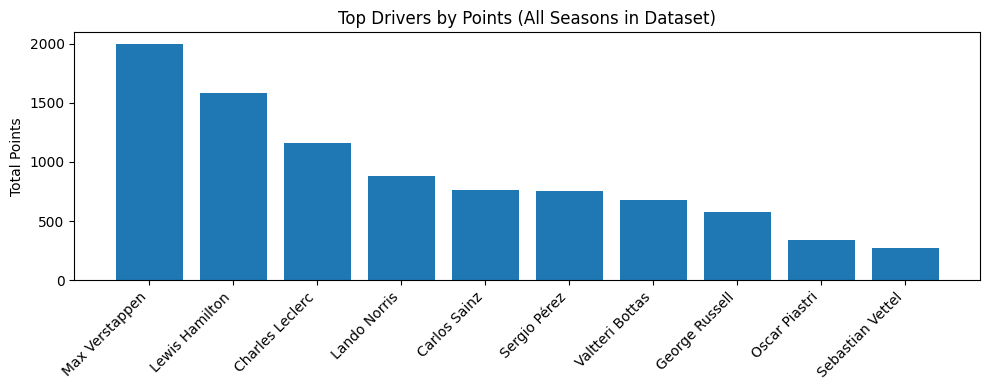

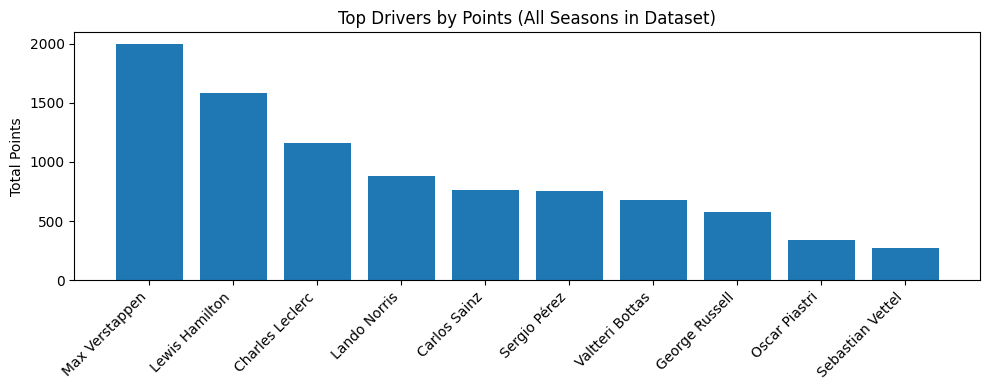

In [258]:

top_drivers = driver_overall.head(10)

plt.figure(figsize=(10, 4))
plt.bar(top_drivers["driver"], top_drivers["total_points"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Points")
plt.title("Top Drivers by Points (All Seasons in Dataset)")
plt.tight_layout()
plt.show()


### 6.3 High-Scoring Drivers: Position Gain vs Average Finish

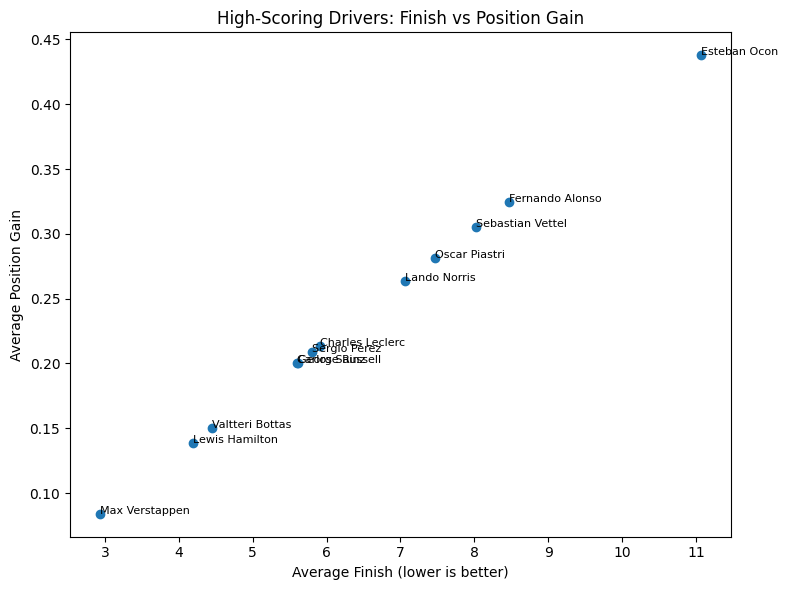

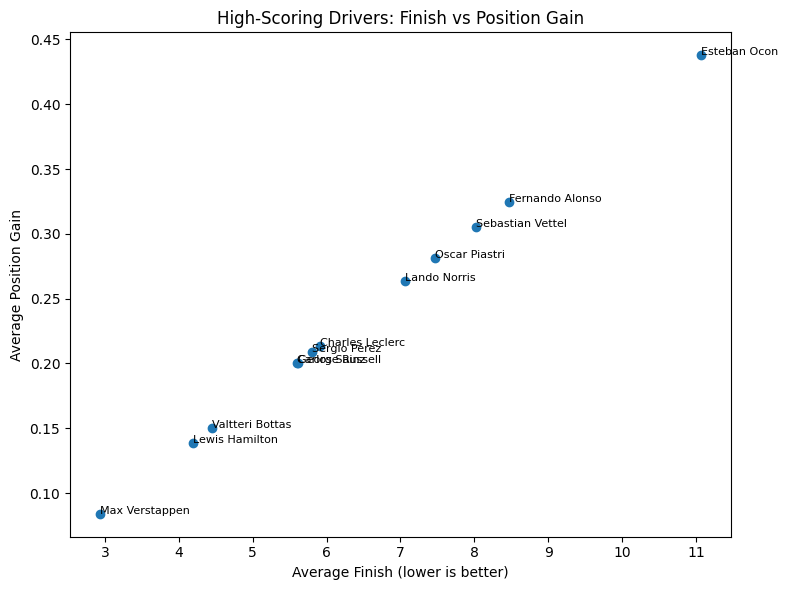

In [259]:
high_scorers = driver_overall[driver_overall["total_points"] > 200]

plt.figure(figsize=(8, 6))
plt.scatter(high_scorers["avg_finish"], high_scorers["avg_pos_gain"])

for _, row in high_scorers.iterrows():
    plt.annotate(row["driver"], (row["avg_finish"], row["avg_pos_gain"]), fontsize=8)

plt.xlabel("Average Finish (lower is better)")
plt.ylabel("Average Position Gain")
plt.title("High-Scoring Drivers: Finish vs Position Gain")
plt.tight_layout()
plt.show()


### 6.4 Drivers: Aggression vs Results

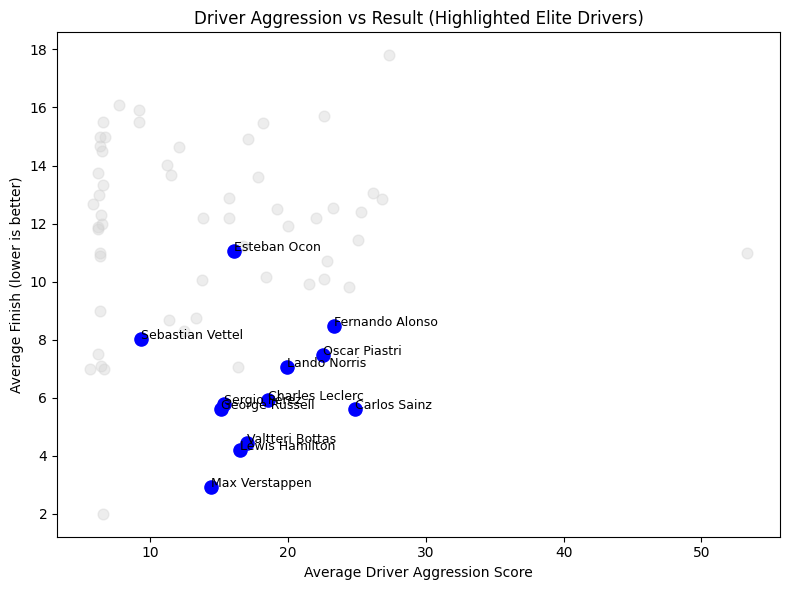

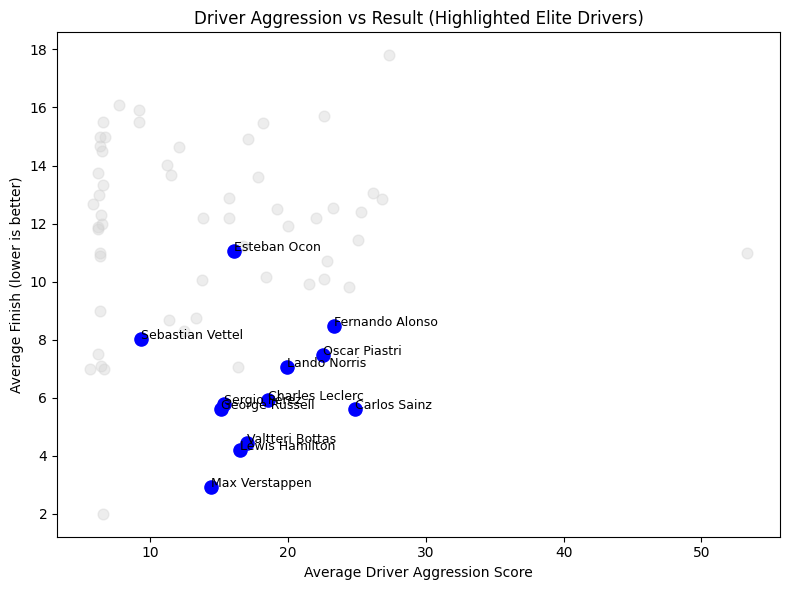

In [260]:
plt.figure(figsize=(8, 6))

# faint background drivers
plt.scatter(driver_overall["avg_driver_aggr"], driver_overall["avg_finish"],
            color="lightgray", alpha=0.4, s=60)

# highlight main drivers
high_scorers = driver_overall[driver_overall["total_points"] > 200]
plt.scatter(high_scorers["avg_driver_aggr"], high_scorers["avg_finish"],
            color="blue", s=90)

for _, row in high_scorers.iterrows():
    plt.annotate(row["driver"], (row["avg_driver_aggr"], row["avg_finish"]), fontsize=9)

plt.xlabel("Average Driver Aggression Score")
plt.ylabel("Average Finish (lower is better)")
plt.title("Driver Aggression vs Result (Highlighted Elite Drivers)")
plt.tight_layout()
plt.show()


# 7. Tire Analytics

6.1 Tire Usage Summary

In [261]:
tire_usage = df.groupby(["season", "tire_compound"], as_index=False).agg(
    usage_count=("tire_compound", "count"),
    avg_stint_length=("stint_length", "mean"),
    avg_aggr=("driver_aggression_score", "mean"),
    avg_pos_gain=("position_changes", "mean")
)

tire_usage.sort_values(["season", "usage_count"], ascending=[True, False]).head(20)

season tire_compound  usage_count  avg_stint_length   avg_aggr  \
2     2018    MEDIUMSOFT           32         30.218750   6.512199   
3     2018          SOFT           26         17.653846   6.596092   
0     2018        MEDIUM           16         28.062500   6.361183   
4     2018     ULTRASOFT            6         10.333333   6.438602   
1     2018    MEDIUMHARD            1         27.000000        NaN   
8     2019    MEDIUMHARD          286         24.090909   6.257069   
7     2019        MEDIUM          266         16.191729   6.319822   
5     2019          HARD          174         34.247126   6.202811   
6     2019  INTERMEDIATE           30         15.966667   6.879272   
9     2019           WET           13          4.076923   6.858481   
13    2020    MEDIUMHARD          292         19.195205  25.676789   
12    2020        MEDIUM          208         15.802885  28.768887   
10    2020          HARD          198         26.287879  19.615342   
11    2020  INTERMEDIATE           56         17.303571   6.371054   
14    2020           WET           18          8.444444   6.280344   
18    2021    MEDIUMHARD          384         18.447917  36.001419   
15    2021          HARD          316         27.303797  34.391229   
17    2021        MEDIUM          191         14.455497  25.170820   
16    2021  INTERMEDIATE          109         15.330275  33.621053   
19    2021           WET            4          8.000000  47.736231   

    avg_pos_gain  
2       0.383152  
3       0.421405  
0       0.353261  
4       0.340580  
1       0.826087  
8       0.367437  
7       0.367767  
5       0.386057  
6       0.310145  
9       0.341137  
13      0.373139  
12      0.336957  
10      0.377251  
11      0.417702  
14      0.357488  
18      0.390738  
15      0.371491  
17      0.378557  
16      0.376147  
19      0.489130

season tire_compound  usage_count  avg_stint_length   avg_aggr  \
2     2018    MEDIUMSOFT           32         30.218750   6.512199   
3     2018          SOFT           26         17.653846   6.596092   
0     2018        MEDIUM           16         28.062500   6.361183   
4     2018     ULTRASOFT            6         10.333333   6.438602   
1     2018    MEDIUMHARD            1         27.000000        NaN   
8     2019    MEDIUMHARD          286         24.090909   6.257069   
7     2019        MEDIUM          266         16.191729   6.319822   
5     2019          HARD          174         34.247126   6.202811   
6     2019  INTERMEDIATE           30         15.966667   6.879272   
9     2019           WET           13          4.076923   6.858481   
13    2020    MEDIUMHARD          292         19.195205  25.676789   
12    2020        MEDIUM          208         15.802885  28.768887   
10    2020          HARD          198         26.287879  19.615342   
11    2020  INTERMEDIATE           56         17.303571   6.371054   
14    2020           WET           18          8.444444   6.280344   
18    2021    MEDIUMHARD          384         18.447917  36.001419   
15    2021          HARD          316         27.303797  34.391229   
17    2021        MEDIUM          191         14.455497  25.170820   
16    2021  INTERMEDIATE          109         15.330275  33.621053   
19    2021           WET            4          8.000000  47.736231   

    avg_pos_gain  
2       0.383152  
3       0.421405  
0       0.353261  
4       0.340580  
1       0.826087  
8       0.367437  
7       0.367767  
5       0.386057  
6       0.310145  
9       0.341137  
13      0.373139  
12      0.336957  
10      0.377251  
11      0.417702  
14      0.357488  
18      0.390738  
15      0.371491  
17      0.378557  
16      0.376147  
19      0.489130

6.2 Global Tire Behavior (across all seasons)

In [262]:
tire_global = df.groupby("tire_compound", as_index=False).agg(
    avg_stint_length=("stint_length", "mean"),
    median_stint_length=("stint_length", "median"),
    avg_aggr=("driver_aggression_score", "mean"),
    avg_pos_gain=("position_changes", "mean"),
    count=("tire_compound", "count")
)

tire_global.sort_values("count", ascending=False)

tire_compound  avg_stint_length  median_stint_length   avg_aggr  \
3    MEDIUMHARD         19.176497                 18.0  20.388566   
0          HARD         26.931200                 27.0  18.513526   
2        MEDIUM         14.368012                 14.0  20.467677   
1  INTERMEDIATE         14.984925                 13.0  22.950893   
7           WET          6.389831                  6.0  14.588077   
4    MEDIUMSOFT         30.218750                 30.0   6.512199   
5          SOFT         17.653846                 17.0   6.596092   
6     ULTRASOFT         10.333333                 10.0   6.438602   

   avg_pos_gain  count  
3      0.375355   2238  
0      0.379641   1875  
2      0.386376   1288  
1      0.375027    398  
7      0.387620     59  
4      0.383152     32  
5      0.421405     26  
6      0.340580      6

tire_compound  avg_stint_length  median_stint_length   avg_aggr  \
3    MEDIUMHARD         19.176497                 18.0  20.388566   
0          HARD         26.931200                 27.0  18.513526   
2        MEDIUM         14.368012                 14.0  20.467677   
1  INTERMEDIATE         14.984925                 13.0  22.950893   
7           WET          6.389831                  6.0  14.588077   
4    MEDIUMSOFT         30.218750                 30.0   6.512199   
5          SOFT         17.653846                 17.0   6.596092   
6     ULTRASOFT         10.333333                 10.0   6.438602   

   avg_pos_gain  count  
3      0.375355   2238  
0      0.379641   1875  
2      0.386376   1288  
1      0.375027    398  
7      0.387620     59  
4      0.383152     32  
5      0.421405     26  
6      0.340580      6

6.3 Plot: Average Stint Length per Compound

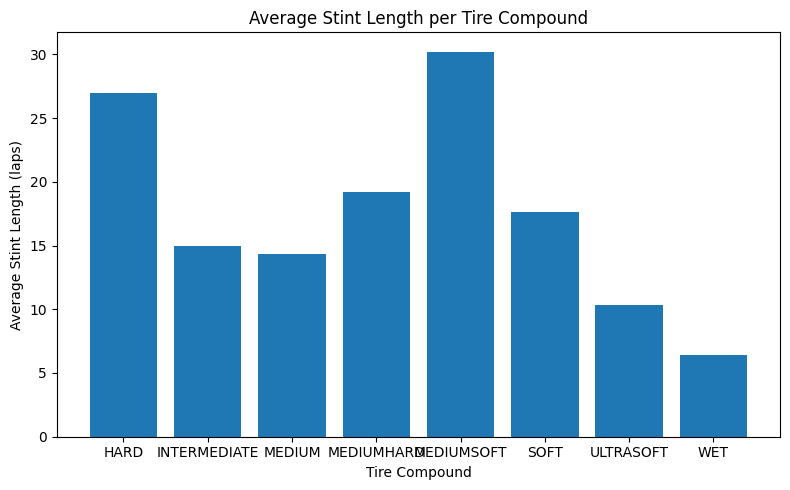

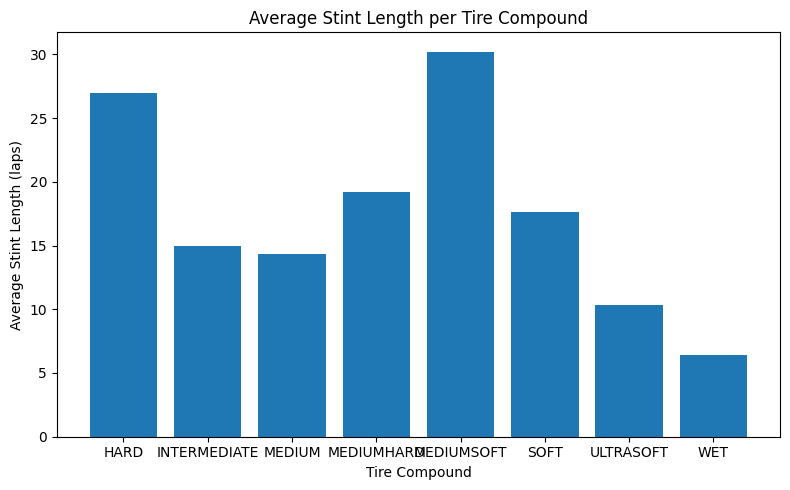

In [263]:
plt.figure(figsize=(8,5))
plt.bar(tire_global["tire_compound"], tire_global["avg_stint_length"])
plt.title("Average Stint Length per Tire Compound")
plt.ylabel("Average Stint Length (laps)")
plt.xlabel("Tire Compound")
plt.tight_layout()
plt.show()

6.4 Plot: Tire Usage per Season

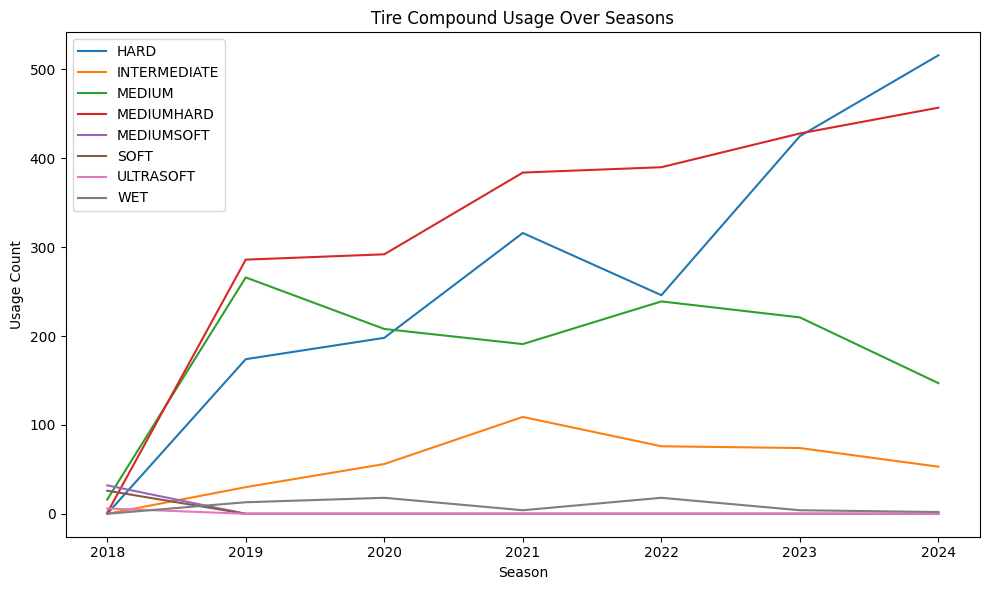

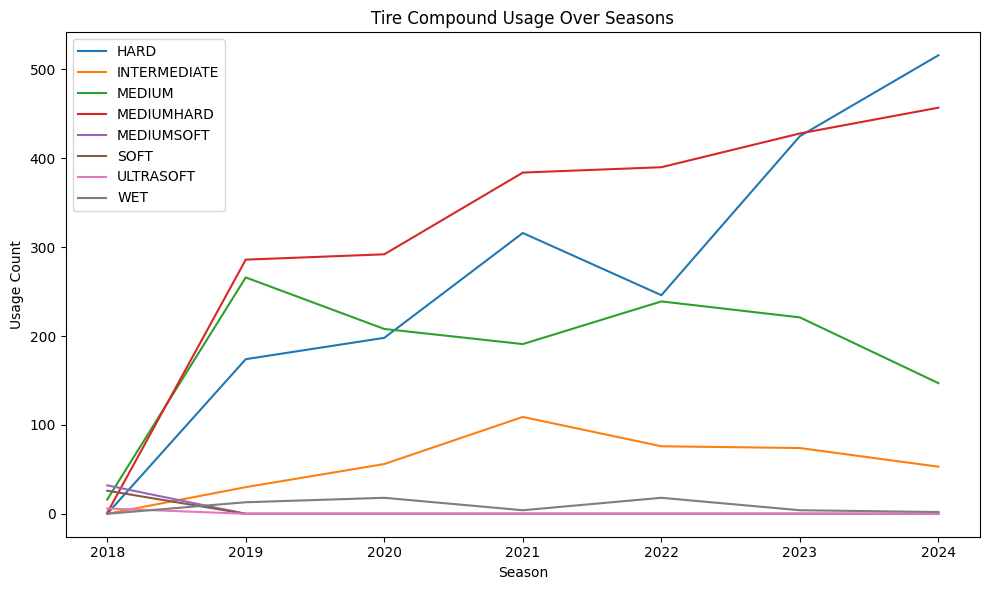

In [264]:
pivot = tire_usage.pivot(index="season", columns="tire_compound", values="usage_count").fillna(0)

plt.figure(figsize=(10,6))
plt.plot(pivot)
plt.title("Tire Compound Usage Over Seasons")
plt.xlabel("Season")
plt.ylabel("Usage Count")
plt.legend(pivot.columns)
plt.tight_layout()
plt.show()

6.5 Tire Performance (Position Gain)

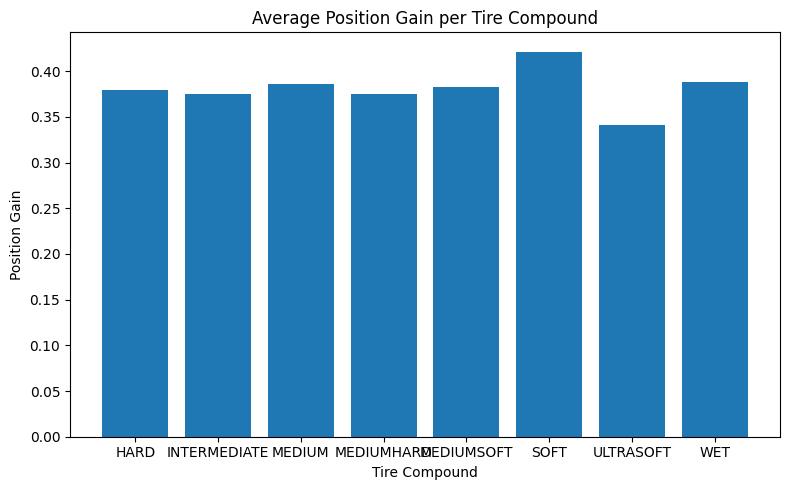

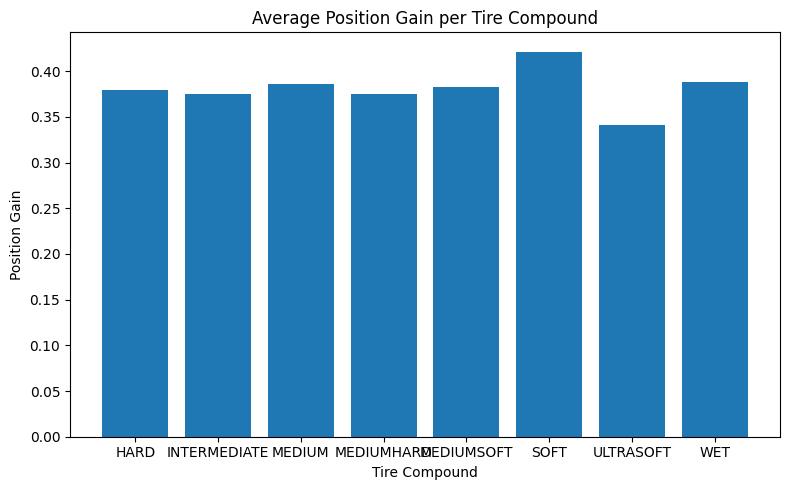

In [265]:
plt.figure(figsize=(8,5))
plt.bar(tire_global["tire_compound"], tire_global["avg_pos_gain"])
plt.title("Average Position Gain per Tire Compound")
plt.ylabel("Position Gain")
plt.xlabel("Tire Compound")
plt.tight_layout()
plt.show()

SOFT gives the most overtaking potential
It has the highest average position gain.

Soft = high grip → faster → easier overtakes.

6.6 Aggression by Tire Compound

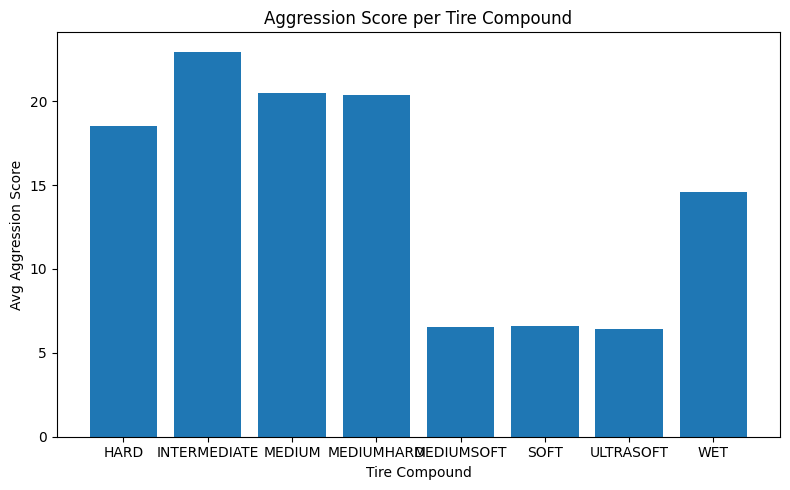

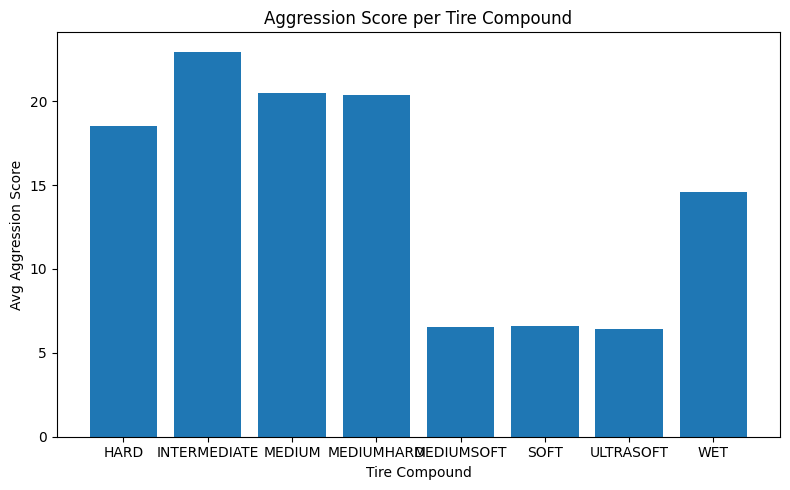

In [266]:
plt.figure(figsize=(8,5))
plt.bar(tire_global["tire_compound"], tire_global["avg_aggr"])
plt.title("Aggression Score per Tire Compound")
plt.ylabel("Avg Aggression Score")
plt.xlabel("Tire Compound")
plt.tight_layout()
plt.show()

Drivers are most aggressive on MEDIUM, MEDIUMHARD and INTERMEDIATE.

2018 → more variety (Soft, Medium, UltraSoft, MediumSoft)
2020–2024 → strategy stabilizes around:

HARD

MEDIUMHARD

MEDIUM occasionally

Teams avoid:

Soft (deg too high)

Wet (only in rare races)

Intermediate (only weather-dependent)

# 7. Race-level Tire Strategy

7.1 Create the race-level tire usage table

In [267]:
race_tire_fingerprint = df.groupby(
    ["season", "race_name", "tire_compound"], as_index=False
).agg(
    usage=("tire_compound", "count"),
    avg_stint_length=("stint_length", "mean"),
    avg_aggr=("driver_aggression_score", "mean"),
    avg_pos_gain=("position_changes", "mean")
)

race_tire_fingerprint.head()


season              race_name tire_compound  usage  avg_stint_length  \
0    2018  Australian Grand Prix    MEDIUMSOFT      1               5.0   
1    2018  Australian Grand Prix          SOFT      3              19.0   
2    2018    Austrian Grand Prix    MEDIUMSOFT      2              33.5   
3    2018    Austrian Grand Prix          SOFT      1              11.0   
4    2018  Azerbaijan Grand Prix          SOFT      1              10.0   

   avg_aggr  avg_pos_gain  
0       NaN      0.782609  
1  6.718005      0.695652  
2       NaN      0.739130  
3       NaN      0.826087  
4       NaN      0.739130

season              race_name tire_compound  usage  avg_stint_length  \
0    2018  Australian Grand Prix    MEDIUMSOFT      1               5.0   
1    2018  Australian Grand Prix          SOFT      3              19.0   
2    2018    Austrian Grand Prix    MEDIUMSOFT      2              33.5   
3    2018    Austrian Grand Prix          SOFT      1              11.0   
4    2018  Azerbaijan Grand Prix          SOFT      1              10.0   

   avg_aggr  avg_pos_gain  
0       NaN      0.782609  
1  6.718005      0.695652  
2       NaN      0.739130  
3       NaN      0.826087  
4       NaN      0.739130

Pivot it - one row per race, columns = tire compounds.

In [268]:
fingerprint_matrix = race_tire_fingerprint.pivot_table(
    index=["season", "race_name"],
    columns="tire_compound",
    values="usage",
    fill_value=0
)

fingerprint_matrix.head(20)

tire_compound                    HARD  INTERMEDIATE  MEDIUM  MEDIUMHARD  \
season race_name                                                          
2018   Australian Grand Prix      0.0           0.0     0.0         0.0   
       Austrian Grand Prix        0.0           0.0     0.0         0.0   
       Azerbaijan Grand Prix      0.0           0.0     0.0         0.0   
       British Grand Prix         0.0           0.0     1.0         0.0   
       French Grand Prix          0.0           0.0     1.0         0.0   
       German Grand Prix          0.0           0.0     0.0         1.0   
       Hungarian Grand Prix       0.0           0.0     0.0         0.0   
       Mexican Grand Prix         0.0           0.0     0.0         0.0   
       United States Grand Prix   0.0           0.0    14.0         0.0   
2019   Australian Grand Prix      7.0           0.0    14.0        12.0   
       Austrian Grand Prix       18.0           0.0    10.0        13.0   
       Azerbaijan Grand Prix      0.0           0.0    22.0        19.0   
       Bahrain Grand Prix         1.0           0.0    24.0        21.0   
       Belgian Grand Prix         0.0           0.0    20.0        16.0   
       British Grand Prix        16.0           0.0    13.0        17.0   
       Canadian Grand Prix       16.0           0.0     5.0        13.0   
       Chinese Grand Prix        18.0           0.0    13.0        24.0   
       French Grand Prix         18.0           0.0     3.0        18.0   
       German Grand Prix          0.0          30.0    21.0         3.0   
       Hungarian Grand Prix      14.0           0.0    10.0        15.0   

tire_compound                    MEDIUMSOFT  SOFT  ULTRASOFT   WET  
season race_name                                                    
2018   Australian Grand Prix            1.0   3.0        0.0   0.0  
       Austrian Grand Prix              2.0   1.0        0.0   0.0  
       Azerbaijan Grand Prix            0.0   1.0        0.0   0.0  
       British Grand Prix               0.0   0.0        0.0   0.0  
       French Grand Prix                0.0   0.0        0.0   0.0  
       German Grand Prix                0.0   0.0        0.0   0.0  
       Hungarian Grand Prix             0.0   1.0        0.0   0.0  
       Mexican Grand Prix              19.0  15.0        6.0   0.0  
       United States Grand Prix        10.0   5.0        0.0   0.0  
2019   Australian Grand Prix            0.0   0.0        0.0   0.0  
       Austrian Grand Prix              0.0   0.0        0.0   0.0  
       Azerbaijan Grand Prix            0.0   0.0        0.0   0.0  
       Bahrain Grand Prix               0.0   0.0        0.0   0.0  
       Belgian Grand Prix               0.0   0.0        0.0   0.0  
       British Grand Prix               0.0   0.0        0.0   0.0  
       Canadian Grand Prix              0.0   0.0        0.0   0.0  
       Chinese Grand Prix               0.0   0.0        0.0   0.0  
       French Grand Prix                0.0   0.0        0.0   0.0  
       German Grand Prix                0.0   0.0        0.0  13.0  
       Hungarian Grand Prix             0.0   0.0        0.0   0.0

tire_compound                    HARD  INTERMEDIATE  MEDIUM  MEDIUMHARD  \
season race_name                                                          
2018   Australian Grand Prix      0.0           0.0     0.0         0.0   
       Austrian Grand Prix        0.0           0.0     0.0         0.0   
       Azerbaijan Grand Prix      0.0           0.0     0.0         0.0   
       British Grand Prix         0.0           0.0     1.0         0.0   
       French Grand Prix          0.0           0.0     1.0         0.0   
       German Grand Prix          0.0           0.0     0.0         1.0   
       Hungarian Grand Prix       0.0           0.0     0.0         0.0   
       Mexican Grand Prix         0.0           0.0     0.0         0.0   
       United States Grand Prix   0.0           0.0    14.0         0.0   
2019   Australian Grand Prix      7.0           0.0    14.0        12.0   
       Austrian Grand Prix       18.0           0.0    10.0        13.0   
       Azerbaijan Grand Prix      0.0           0.0    22.0        19.0   
       Bahrain Grand Prix         1.0           0.0    24.0        21.0   
       Belgian Grand Prix         0.0           0.0    20.0        16.0   
       British Grand Prix        16.0           0.0    13.0        17.0   
       Canadian Grand Prix       16.0           0.0     5.0        13.0   
       Chinese Grand Prix        18.0           0.0    13.0        24.0   
       French Grand Prix         18.0           0.0     3.0        18.0   
       German Grand Prix          0.0          30.0    21.0         3.0   
       Hungarian Grand Prix      14.0           0.0    10.0        15.0   

tire_compound                    MEDIUMSOFT  SOFT  ULTRASOFT   WET  
season race_name                                                    
2018   Australian Grand Prix            1.0   3.0        0.0   0.0  
       Austrian Grand Prix              2.0   1.0        0.0   0.0  
       Azerbaijan Grand Prix            0.0   1.0        0.0   0.0  
       British Grand Prix               0.0   0.0        0.0   0.0  
       French Grand Prix                0.0   0.0        0.0   0.0  
       German Grand Prix                0.0   0.0        0.0   0.0  
       Hungarian Grand Prix             0.0   1.0        0.0   0.0  
       Mexican Grand Prix              19.0  15.0        6.0   0.0  
       United States Grand Prix        10.0   5.0        0.0   0.0  
2019   Australian Grand Prix            0.0   0.0        0.0   0.0  
       Austrian Grand Prix              0.0   0.0        0.0   0.0  
       Azerbaijan Grand Prix            0.0   0.0        0.0   0.0  
       Bahrain Grand Prix               0.0   0.0        0.0   0.0  
       Belgian Grand Prix               0.0   0.0        0.0   0.0  
       British Grand Prix               0.0   0.0        0.0   0.0  
       Canadian Grand Prix              0.0   0.0        0.0   0.0  
       Chinese Grand Prix               0.0   0.0        0.0   0.0  
       French Grand Prix                0.0   0.0        0.0   0.0  
       German Grand Prix                0.0   0.0        0.0  13.0  
       Hungarian Grand Prix             0.0   0.0        0.0   0.0

7.2 Tire Efficiency Metric (How good is each tire at converting laps into positions gained?)

Tire Efficiency = (Position Gain) / (Stint Length)

Calculate efficiency per stint

In [269]:
df["tire_efficiency"] = df["position_changes"] / df["stint_length"]
df["tire_efficiency"].replace([float('inf'), -float('inf')], 0, inplace=True)
df["tire_efficiency"] = df["tire_efficiency"].fillna(0)

/tmp/ipython-input-1609519842.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["tire_efficiency"].replace([float('inf'), -float('inf')], 0, inplace=True)
/tmp/ipython-input-1609519842.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(

Average efficiency per tire

In [270]:
tire_eff = df.groupby("tire_compound", as_index=False).agg(
    avg_efficiency=("tire_efficiency", "mean"),
    avg_pos_gain=("position_changes", "mean"),
    avg_stint_length=("stint_length", "mean"),
    usage=("tire_compound", "count")
)

tire_eff.sort_values("avg_efficiency", ascending=False)

tire_compound  avg_efficiency  avg_pos_gain  avg_stint_length  usage
7           WET        0.091270      0.387620          6.389831     59
1  INTERMEDIATE        0.086229      0.375027         14.984925    398
2        MEDIUM        0.077931      0.386376         14.368012   1288
4    MEDIUMSOFT        0.070343      0.383152         30.218750     32
3    MEDIUMHARD        0.049779      0.375355         19.176497   2238
6     ULTRASOFT        0.040241      0.340580         10.333333      6
5          SOFT        0.032237      0.421405         17.653846     26
0          HARD        0.030993      0.379641         26.931200   1875

tire_compound  avg_efficiency  avg_pos_gain  avg_stint_length  usage
7           WET        0.091270      0.387620          6.389831     59
1  INTERMEDIATE        0.086229      0.375027         14.984925    398
2        MEDIUM        0.077931      0.386376         14.368012   1288
4    MEDIUMSOFT        0.070343      0.383152         30.218750     32
3    MEDIUMHARD        0.049779      0.375355         19.176497   2238
6     ULTRASOFT        0.040241      0.340580         10.333333      6
5          SOFT        0.032237      0.421405         17.653846     26
0          HARD        0.030993      0.379641         26.931200   1875

Plot tire efficiency

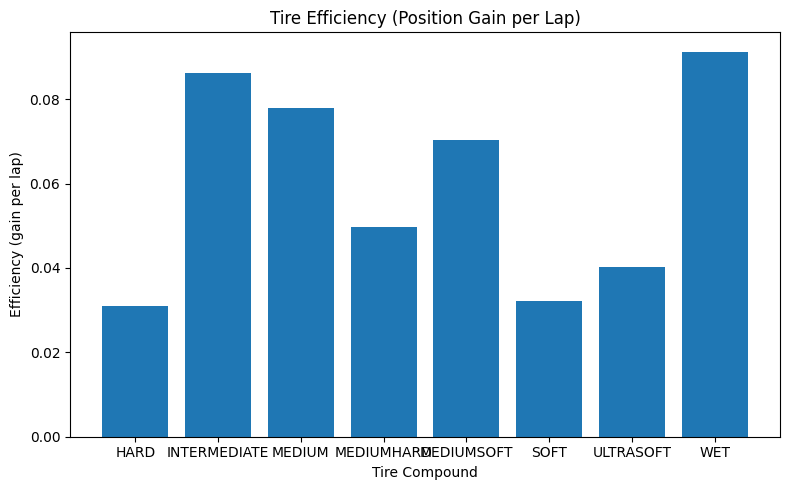

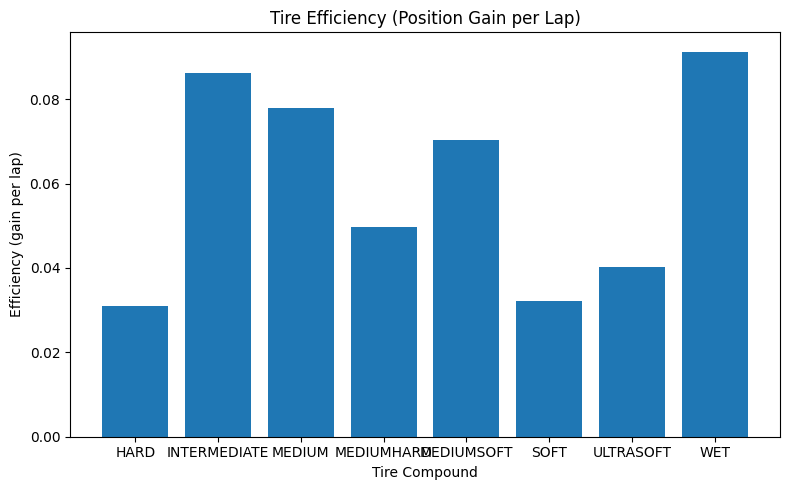

In [271]:
plt.figure(figsize=(8,5))
plt.bar(tire_eff["tire_compound"], tire_eff["avg_efficiency"])
plt.title("Tire Efficiency (Position Gain per Lap)")
plt.ylabel("Efficiency (gain per lap)")
plt.xlabel("Tire Compound")
plt.tight_layout()
plt.show()

# 8. Driver-level tire efficiency

8.1 Compute driver-level tire efficiency

In [272]:
df["tire_efficiency"] = df["position_changes"] / df["stint_length"]
df["tire_efficiency"] = df["tire_efficiency"].replace([float('inf'), -float('inf')], 0).fillna(0)

# Aggregate per driver & compound
driver_tire_eff = df.groupby(["driver", "tire_compound"], as_index=False).agg(
    avg_efficiency=("tire_efficiency", "mean"),
    avg_pos_gain=("position_changes", "mean"),
    avg_stint_length=("stint_length", "mean"),
    usage=("tire_compound", "count")
)

driver_tire_eff.sort_values(["tire_compound", "avg_efficiency"], ascending=[True, False]).head(20)


driver tire_compound  avg_efficiency  avg_pos_gain  \
96          Liam Lawson          HARD        0.128929      0.550725   
187        Yuki Tsunoda          HARD        0.069708      0.496129   
157     Romain Grosjean          HARD        0.057653      0.583524   
63      Kevin Magnussen          HARD        0.057645      0.593822   
100      Logan Sargeant          HARD        0.057240      0.679348   
56          Guanyu Zhou          HARD        0.048727      0.547431   
70       Kimi Raikkönen          HARD        0.045025      0.512516   
119     Nicholas Latifi          HARD        0.042789      0.631579   
5    Antonio Giovinazzi          HARD        0.042018      0.539130   
132      Nikita Mazepin          HARD        0.036965      0.739130   
43      Fernando Alonso          HARD        0.034766      0.343532   
77         Lance Stroll          HARD        0.033871      0.451259   
0       Alexander Albon          HARD        0.033098      0.464194   
149        Pierre Gasly          HARD        0.032992      0.418855   
179     Valtteri Bottas          HARD        0.031880      0.415262   
114     Mick Schumacher          HARD        0.028648      0.627090   
51       George Russell          HARD        0.027968      0.335724   
84         Lando Norris          HARD        0.025380      0.266035   
165    Sebastian Vettel          HARD        0.024528      0.407956   
137       Nyck de Vries          HARD        0.024339      0.646739   

     avg_stint_length  usage  
96          20.333333     12  
187         26.287671     73  
157         23.105263     19  
63          25.592105     76  
100         25.375000     32  
56          23.606061     66  
70          27.848485     33  
119         28.263158     38  
5           29.685714     35  
132         26.090909     11  
43          24.839506     81  
77          26.347368     95  
0           28.955882     68  
149         26.039604    101  
179         26.959184     98  
114         26.500000     26  
51          26.628866     97  
84          26.089109    101  
165         27.021277     47  
137         29.000000      8

driver tire_compound  avg_efficiency  avg_pos_gain  \
96          Liam Lawson          HARD        0.128929      0.550725   
187        Yuki Tsunoda          HARD        0.069708      0.496129   
157     Romain Grosjean          HARD        0.057653      0.583524   
63      Kevin Magnussen          HARD        0.057645      0.593822   
100      Logan Sargeant          HARD        0.057240      0.679348   
56          Guanyu Zhou          HARD        0.048727      0.547431   
70       Kimi Raikkönen          HARD        0.045025      0.512516   
119     Nicholas Latifi          HARD        0.042789      0.631579   
5    Antonio Giovinazzi          HARD        0.042018      0.539130   
132      Nikita Mazepin          HARD        0.036965      0.739130   
43      Fernando Alonso          HARD        0.034766      0.343532   
77         Lance Stroll          HARD        0.033871      0.451259   
0       Alexander Albon          HARD        0.033098      0.464194   
149        Pierre Gasly          HARD        0.032992      0.418855   
179     Valtteri Bottas          HARD        0.031880      0.415262   
114     Mick Schumacher          HARD        0.028648      0.627090   
51       George Russell          HARD        0.027968      0.335724   
84         Lando Norris          HARD        0.025380      0.266035   
165    Sebastian Vettel          HARD        0.024528      0.407956   
137       Nyck de Vries          HARD        0.024339      0.646739   

     avg_stint_length  usage  
96          20.333333     12  
187         26.287671     73  
157         23.105263     19  
63          25.592105     76  
100         25.375000     32  
56          23.606061     66  
70          27.848485     33  
119         28.263158     38  
5           29.685714     35  
132         26.090909     11  
43          24.839506     81  
77          26.347368     95  
0           28.955882     68  
149         26.039604    101  
179         26.959184     98  
114         26.500000     26  
51          26.628866     97  
84          26.089109    101  
165         27.021277     47  
137         29.000000      8

8.2 top 5 most efficient drivers per compound

In [273]:
top_drivers_by_compound = (
    driver_tire_eff.sort_values(["tire_compound", "avg_efficiency"], ascending=[True, False])
    .groupby("tire_compound").head(5)
)

top_drivers_by_compound

driver tire_compound  avg_efficiency  avg_pos_gain  \
96          Liam Lawson          HARD        0.128929      0.550725   
187        Yuki Tsunoda          HARD        0.069708      0.496129   
157     Romain Grosjean          HARD        0.057653      0.583524   
63      Kevin Magnussen          HARD        0.057645      0.593822   
100      Logan Sargeant          HARD        0.057240      0.679348   
133      Nikita Mazepin  INTERMEDIATE        0.281380      0.683230   
97          Liam Lawson  INTERMEDIATE        0.193841      0.521739   
6    Antonio Giovinazzi  INTERMEDIATE        0.183445      0.541063   
120     Nicholas Latifi  INTERMEDIATE        0.162206      0.597826   
115     Mick Schumacher  INTERMEDIATE        0.140777      0.642512   
134      Nikita Mazepin        MEDIUM        0.175621      0.644269   
98          Liam Lawson        MEDIUM        0.153636      0.559006   
159     Romain Grosjean        MEDIUM        0.143782      0.554865   
58          Guanyu Zhou        MEDIUM        0.131257      0.554069   
121     Nicholas Latifi        MEDIUM        0.121259      0.672360   
135      Nikita Mazepin    MEDIUMHARD        0.187197      0.746377   
8    Antonio Giovinazzi    MEDIUMHARD        0.098005      0.553973   
103      Logan Sargeant    MEDIUMHARD        0.096948      0.655797   
117     Mick Schumacher    MEDIUMHARD        0.088766      0.622851   
122     Nicholas Latifi    MEDIUMHARD        0.086715      0.646377   
47      Fernando Alonso    MEDIUMSOFT        0.739130      0.739130   
40         Esteban Ocon    MEDIUMSOFT        0.224888      0.434783   
11      Brendon Hartley    MEDIUMSOFT        0.150886      0.543478   
105     Marcus Ericsson    MEDIUMSOFT        0.059579      0.507246   
153        Pierre Gasly    MEDIUMSOFT        0.025187      0.420290   
112      Max Verstappen          SOFT        0.078261      0.391304   
129     Nico Hülkenberg          SOFT        0.052821      0.594203   
177        Sergio Pérez          SOFT        0.052283      0.521739   
82         Lance Stroll          SOFT        0.042308      0.478261   
154        Pierre Gasly          SOFT        0.041014      0.608696   
163     Romain Grosjean     ULTRASOFT        0.081522      0.652174   
155        Pierre Gasly     ULTRASOFT        0.078261      0.391304   
106     Marcus Ericsson     ULTRASOFT        0.021739      0.347826   
185     Valtteri Bottas     ULTRASOFT        0.021739      0.173913   
24      Charles Leclerc     ULTRASOFT        0.020067      0.260870   
156        Pierre Gasly           WET        0.239441      0.565217   
42         Esteban Ocon           WET        0.210531      0.347826   
9    Antonio Giovinazzi           WET        0.173913      0.521739   
76       Kimi Raikkönen           WET        0.117754      0.543478   
186     Valtteri Bottas           WET        0.116460      0.586957   

     avg_stint_length  usage  
96          20.333333     12  
187         26.287671     73  
157         23.105263     19  
63          25.592105     76  
100         25.375000     32  
133         10.714286      7  
97           5.500000      4  
6           14.888889      9  
120         12.666667     12  
115         16.222222      9  
134         12.272727     11  
98           8.000000      7  
159         16.190476     21  
58          10.820513     39  
121         13.750000     28  
135         17.000000     18  
8           18.741379     58  
103         14.527778     36  
117         19.348837     43  
122         16.300000     60  
47           1.000000      1  
40          15.000000      2  
11          31.750000      4  
105         27.666667      3  
153         24.666667      3  
112          9.000000      2  
129         14.666667      3  
177         16.500000      2  
82          11.500000      2  
154         16.000000      2  
163          8.000000      1  
155          5.000000      1  
106         16.000000      1  
185          8.000000      1  
24          13.00000

driver tire_compound  avg_efficiency  avg_pos_gain  \
96          Liam Lawson          HARD        0.128929      0.550725   
187        Yuki Tsunoda          HARD        0.069708      0.496129   
157     Romain Grosjean          HARD        0.057653      0.583524   
63      Kevin Magnussen          HARD        0.057645      0.593822   
100      Logan Sargeant          HARD        0.057240      0.679348   
133      Nikita Mazepin  INTERMEDIATE        0.281380      0.683230   
97          Liam Lawson  INTERMEDIATE        0.193841      0.521739   
6    Antonio Giovinazzi  INTERMEDIATE        0.183445      0.541063   
120     Nicholas Latifi  INTERMEDIATE        0.162206      0.597826   
115     Mick Schumacher  INTERMEDIATE        0.140777      0.642512   
134      Nikita Mazepin        MEDIUM        0.175621      0.644269   
98          Liam Lawson        MEDIUM        0.153636      0.559006   
159     Romain Grosjean        MEDIUM        0.143782      0.554865   
58          Guanyu Zhou        MEDIUM        0.131257      0.554069   
121     Nicholas Latifi        MEDIUM        0.121259      0.672360   
135      Nikita Mazepin    MEDIUMHARD        0.187197      0.746377   
8    Antonio Giovinazzi    MEDIUMHARD        0.098005      0.553973   
103      Logan Sargeant    MEDIUMHARD        0.096948      0.655797   
117     Mick Schumacher    MEDIUMHARD        0.088766      0.622851   
122     Nicholas Latifi    MEDIUMHARD        0.086715      0.646377   
47      Fernando Alonso    MEDIUMSOFT        0.739130      0.739130   
40         Esteban Ocon    MEDIUMSOFT        0.224888      0.434783   
11      Brendon Hartley    MEDIUMSOFT        0.150886      0.543478   
105     Marcus Ericsson    MEDIUMSOFT        0.059579      0.507246   
153        Pierre Gasly    MEDIUMSOFT        0.025187      0.420290   
112      Max Verstappen          SOFT        0.078261      0.391304   
129     Nico Hülkenberg          SOFT        0.052821      0.594203   
177        Sergio Pérez          SOFT        0.052283      0.521739   
82         Lance Stroll          SOFT        0.042308      0.478261   
154        Pierre Gasly          SOFT        0.041014      0.608696   
163     Romain Grosjean     ULTRASOFT        0.081522      0.652174   
155        Pierre Gasly     ULTRASOFT        0.078261      0.391304   
106     Marcus Ericsson     ULTRASOFT        0.021739      0.347826   
185     Valtteri Bottas     ULTRASOFT        0.021739      0.173913   
24      Charles Leclerc     ULTRASOFT        0.020067      0.260870   
156        Pierre Gasly           WET        0.239441      0.565217   
42         Esteban Ocon           WET        0.210531      0.347826   
9    Antonio Giovinazzi           WET        0.173913      0.521739   
76       Kimi Raikkönen           WET        0.117754      0.543478   
186     Valtteri Bottas           WET        0.116460      0.586957   

     avg_stint_length  usage  
96          20.333333     12  
187         26.287671     73  
157         23.105263     19  
63          25.592105     76  
100         25.375000     32  
133         10.714286      7  
97           5.500000      4  
6           14.888889      9  
120         12.666667     12  
115         16.222222      9  
134         12.272727     11  
98           8.000000      7  
159         16.190476     21  
58          10.820513     39  
121         13.750000     28  
135         17.000000     18  
8           18.741379     58  
103         14.527778     36  
117         19.348837     43  
122         16.300000     60  
47           1.000000      1  
40          15.000000      2  
11          31.750000      4  
105         27.666667      3  
153         24.666667      3  
112          9.000000      2  
129         14.666667      3  
177         16.500000      2  
82          11.500000      2  
154         16.000000      2  
163          8.000000      1  
155          5.000000      1  
106         16.000000      1  
185          8.000000      1  
24          13.00000

8.3 Plot: For each compound, who is the most efficient driver?

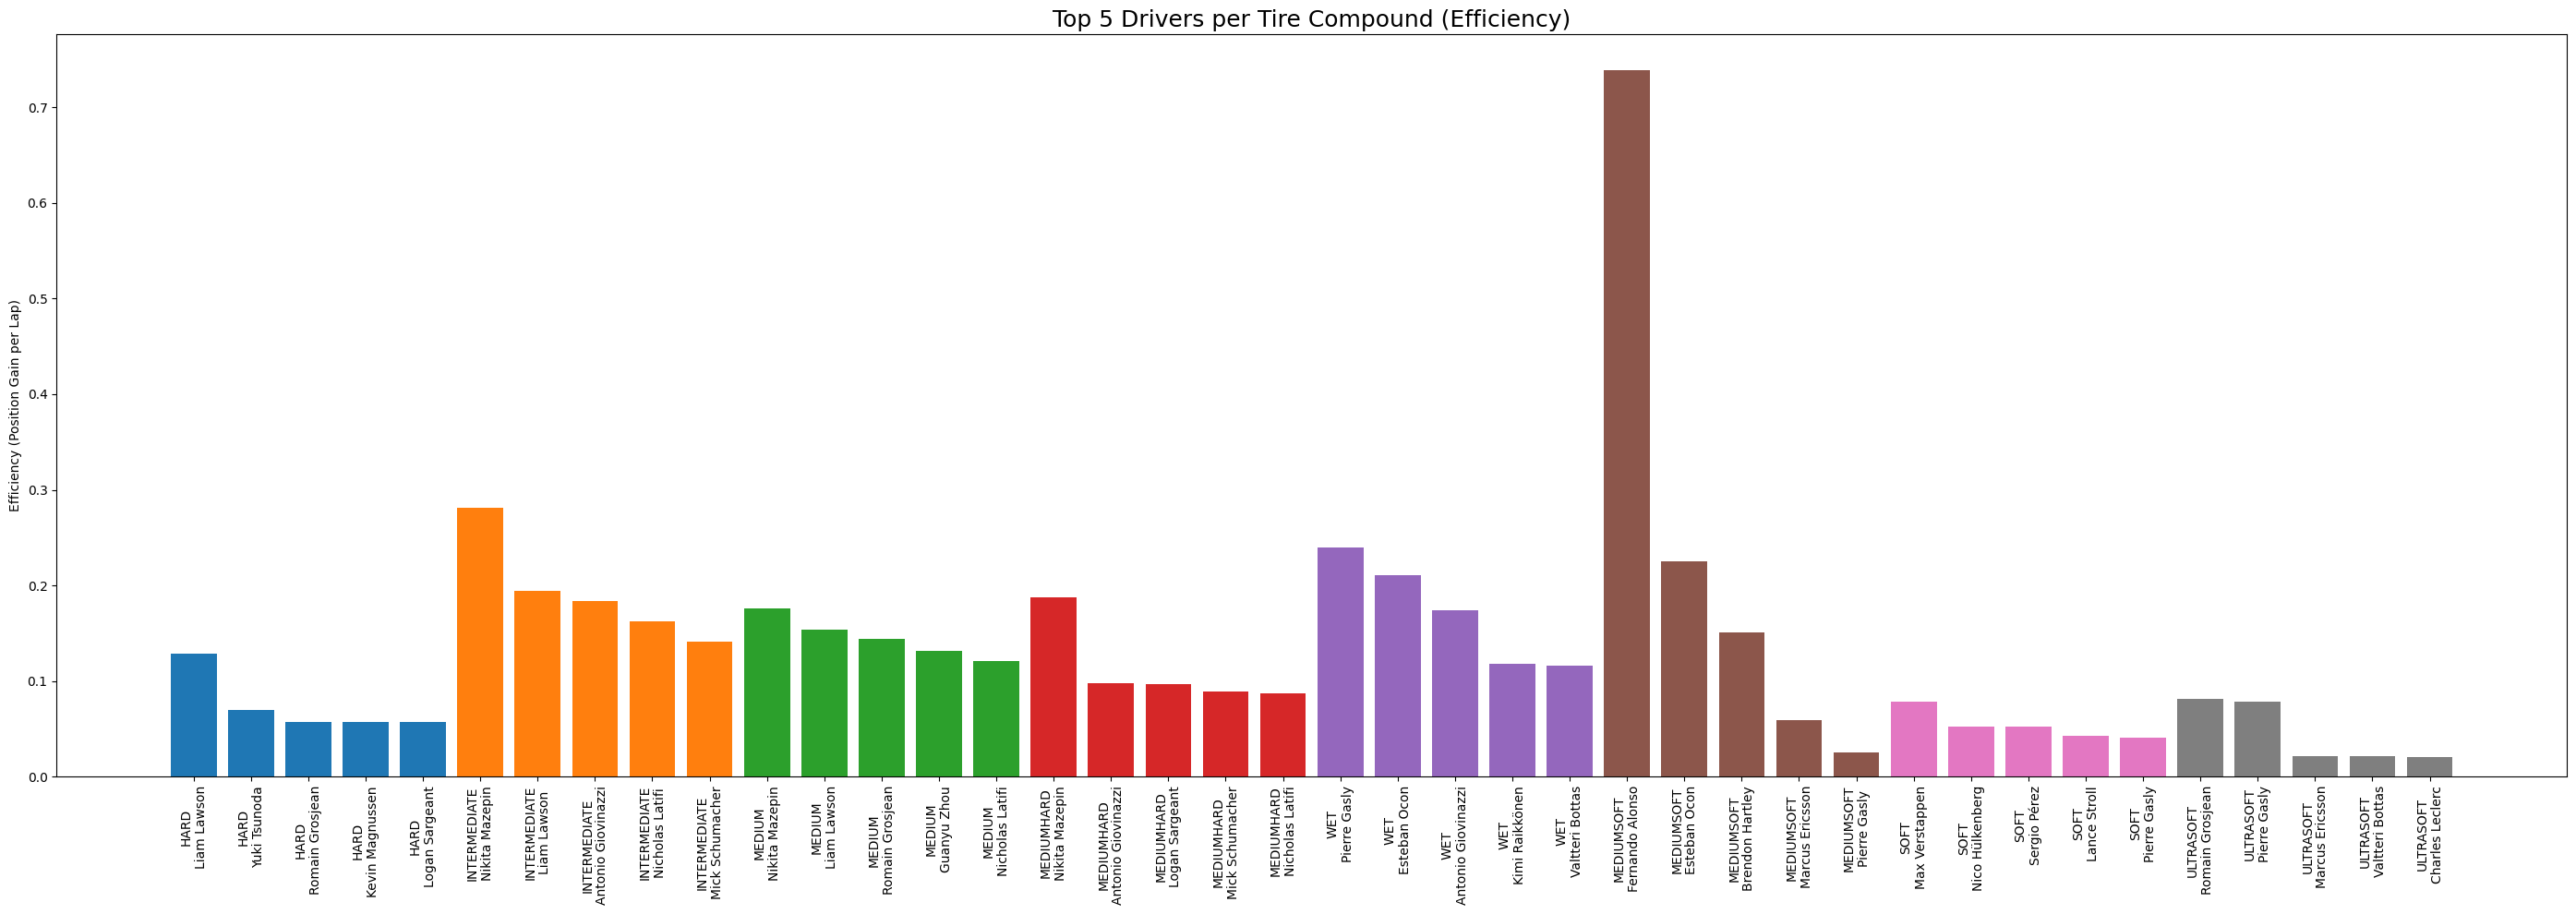

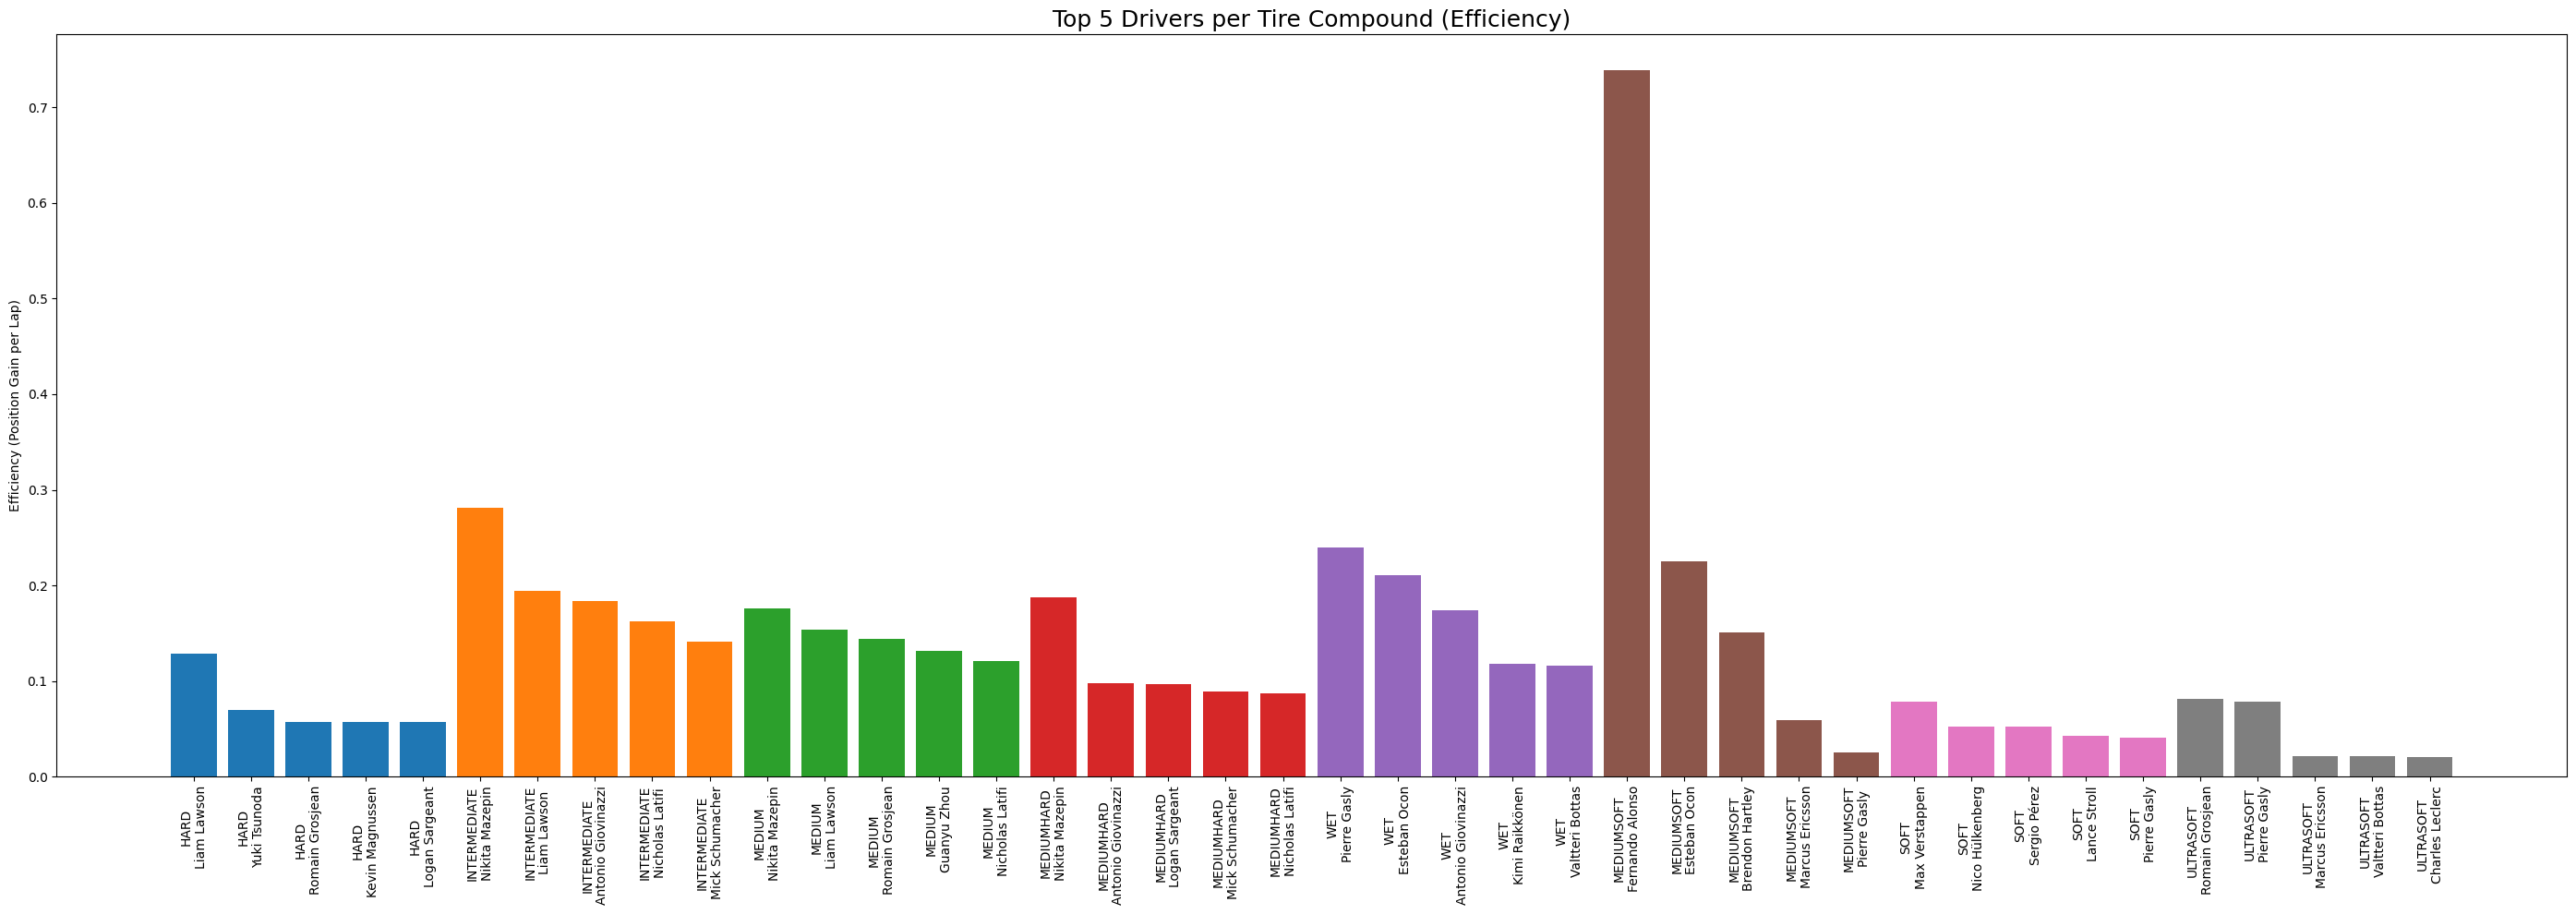

In [274]:
import matplotlib.pyplot as plt

unique_compounds = driver_tire_eff["tire_compound"].unique()

plt.figure(figsize=(28,10))

for compound in unique_compounds:
    subset = driver_tire_eff[driver_tire_eff["tire_compound"] == compound] \
                .sort_values("avg_efficiency", ascending=False).head(5)

    plt.bar(
        [f"{compound}\n{d}" for d in subset["driver"]],
        subset["avg_efficiency"]
    )

plt.xticks(rotation=90, fontsize=10)
plt.ylabel("Efficiency (Position Gain per Lap)")
plt.title("Top 5 Drivers per Tire Compound (Efficiency)", fontsize=18)
plt.tight_layout()
plt.show()


# 9. Team-Level Tire Profiles

9.1 Compute team-level tire metrics

In [275]:
team_tire_profile = df.groupby(["constructor", "tire_compound"], as_index=False).agg(
    avg_efficiency=("tire_efficiency", "mean"),
    avg_stint_length=("stint_length", "mean"),
    avg_aggr=("driver_aggression_score", "mean"),
    avg_pos_gain=("position_changes", "mean"),
    usage=("tire_compound", "count")
)

team_tire_profile.sort_values(["constructor", "tire_compound"]).head(20)

constructor tire_compound  avg_efficiency  avg_stint_length   avg_aggr  \
0       Alfa Romeo          HARD        0.042779         26.811189  21.173408   
1       Alfa Romeo  INTERMEDIATE        0.129609         14.647059  20.411445   
2       Alfa Romeo        MEDIUM        0.110848         13.626168  20.185432   
3       Alfa Romeo    MEDIUMHARD        0.079212         19.063158  23.069085   
4       Alfa Romeo           WET        0.130952          5.000000  11.037290   
5       AlphaTauri          HARD        0.040548         26.647541  25.873737   
6       AlphaTauri  INTERMEDIATE        0.140774         12.944444  26.480494   
7       AlphaTauri        MEDIUM        0.084748         13.594059  27.082939   
8       AlphaTauri    MEDIUMHARD        0.065923         17.961832  24.481593   
9       AlphaTauri           WET        0.186982          7.166667  15.517891   
10  Alpine F1 Team          HARD        0.031011         26.603896  19.418042   
11  Alpine F1 Team  INTERMEDIATE        0.065419         13.967742  30.496150   
12  Alpine F1 Team        MEDIUM        0.106066         13.118421  19.379889   
13  Alpine F1 Team    MEDIUMHARD        0.058539         18.542484  20.962311   
14  Alpine F1 Team           WET        0.153261          3.500000  31.809594   
15    Aston Martin          HARD        0.033651         25.526316  20.078859   
16    Aston Martin  INTERMEDIATE        0.095450         14.529412  24.673137   
17    Aston Martin        MEDIUM        0.081281         14.217391  25.460804   
18    Aston Martin    MEDIUMHARD        0.057354         18.415663  24.669096   
19    Aston Martin           WET        0.084058          4.000000  17.653389   

    avg_pos_gain  usage  
0       0.521435    143  
1       0.525575     34  
2       0.508736    107  
3       0.530892    190  
4       0.573913      5  
5       0.454383    122  
6       0.490338     36  
7       0.462764    101  
8       0.461334    131  
9       0.543478      6  
10      0.436477    154  
11      0.323983     31  
12      0.420481     76  
13      0.433362    153  
14      0.282609      4  
15      0.408467    152  
16      0.375959     34  
17      0.422495     92  
18      0.429282    166  
19      0.347826      2

constructor tire_compound  avg_efficiency  avg_stint_length   avg_aggr  \
0       Alfa Romeo          HARD        0.042779         26.811189  21.173408   
1       Alfa Romeo  INTERMEDIATE        0.129609         14.647059  20.411445   
2       Alfa Romeo        MEDIUM        0.110848         13.626168  20.185432   
3       Alfa Romeo    MEDIUMHARD        0.079212         19.063158  23.069085   
4       Alfa Romeo           WET        0.130952          5.000000  11.037290   
5       AlphaTauri          HARD        0.040548         26.647541  25.873737   
6       AlphaTauri  INTERMEDIATE        0.140774         12.944444  26.480494   
7       AlphaTauri        MEDIUM        0.084748         13.594059  27.082939   
8       AlphaTauri    MEDIUMHARD        0.065923         17.961832  24.481593   
9       AlphaTauri           WET        0.186982          7.166667  15.517891   
10  Alpine F1 Team          HARD        0.031011         26.603896  19.418042   
11  Alpine F1 Team  INTERMEDIATE        0.065419         13.967742  30.496150   
12  Alpine F1 Team        MEDIUM        0.106066         13.118421  19.379889   
13  Alpine F1 Team    MEDIUMHARD        0.058539         18.542484  20.962311   
14  Alpine F1 Team           WET        0.153261          3.500000  31.809594   
15    Aston Martin          HARD        0.033651         25.526316  20.078859   
16    Aston Martin  INTERMEDIATE        0.095450         14.529412  24.673137   
17    Aston Martin        MEDIUM        0.081281         14.217391  25.460804   
18    Aston Martin    MEDIUMHARD        0.057354         18.415663  24.669096   
19    Aston Martin           WET        0.084058          4.000000  17.653389   

    avg_pos_gain  usage  
0       0.521435    143  
1       0.525575     34  
2       0.508736    107  
3       0.530892    190  
4       0.573913      5  
5       0.454383    122  
6       0.490338     36  
7       0.462764    101  
8       0.461334    131  
9       0.543478      6  
10      0.436477    154  
11      0.323983     31  
12      0.420481     76  
13      0.433362    153  
14      0.282609      4  
15      0.408467    152  
16      0.375959     34  
17      0.422495     92  
18      0.429282    166  
19      0.347826      2

9.2 Plot: team tire efficiency

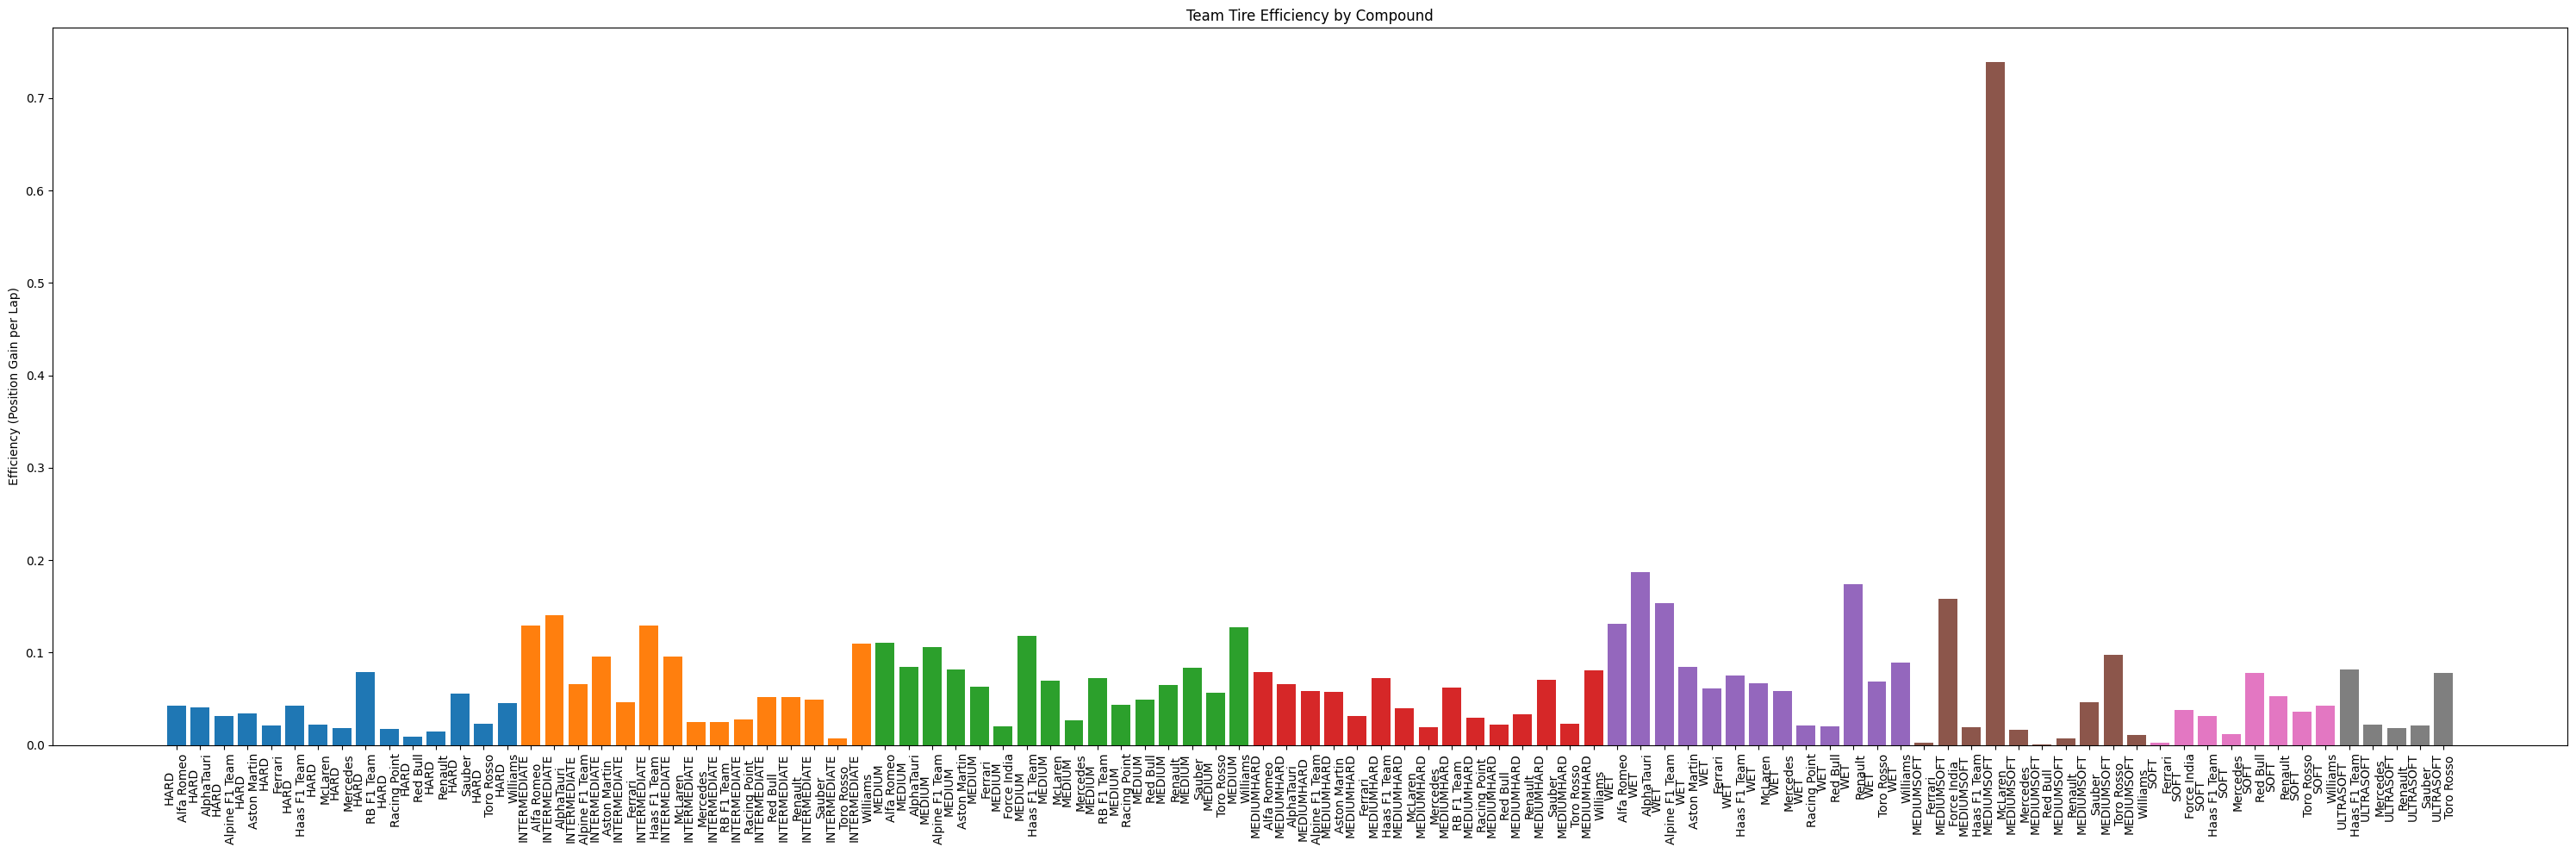

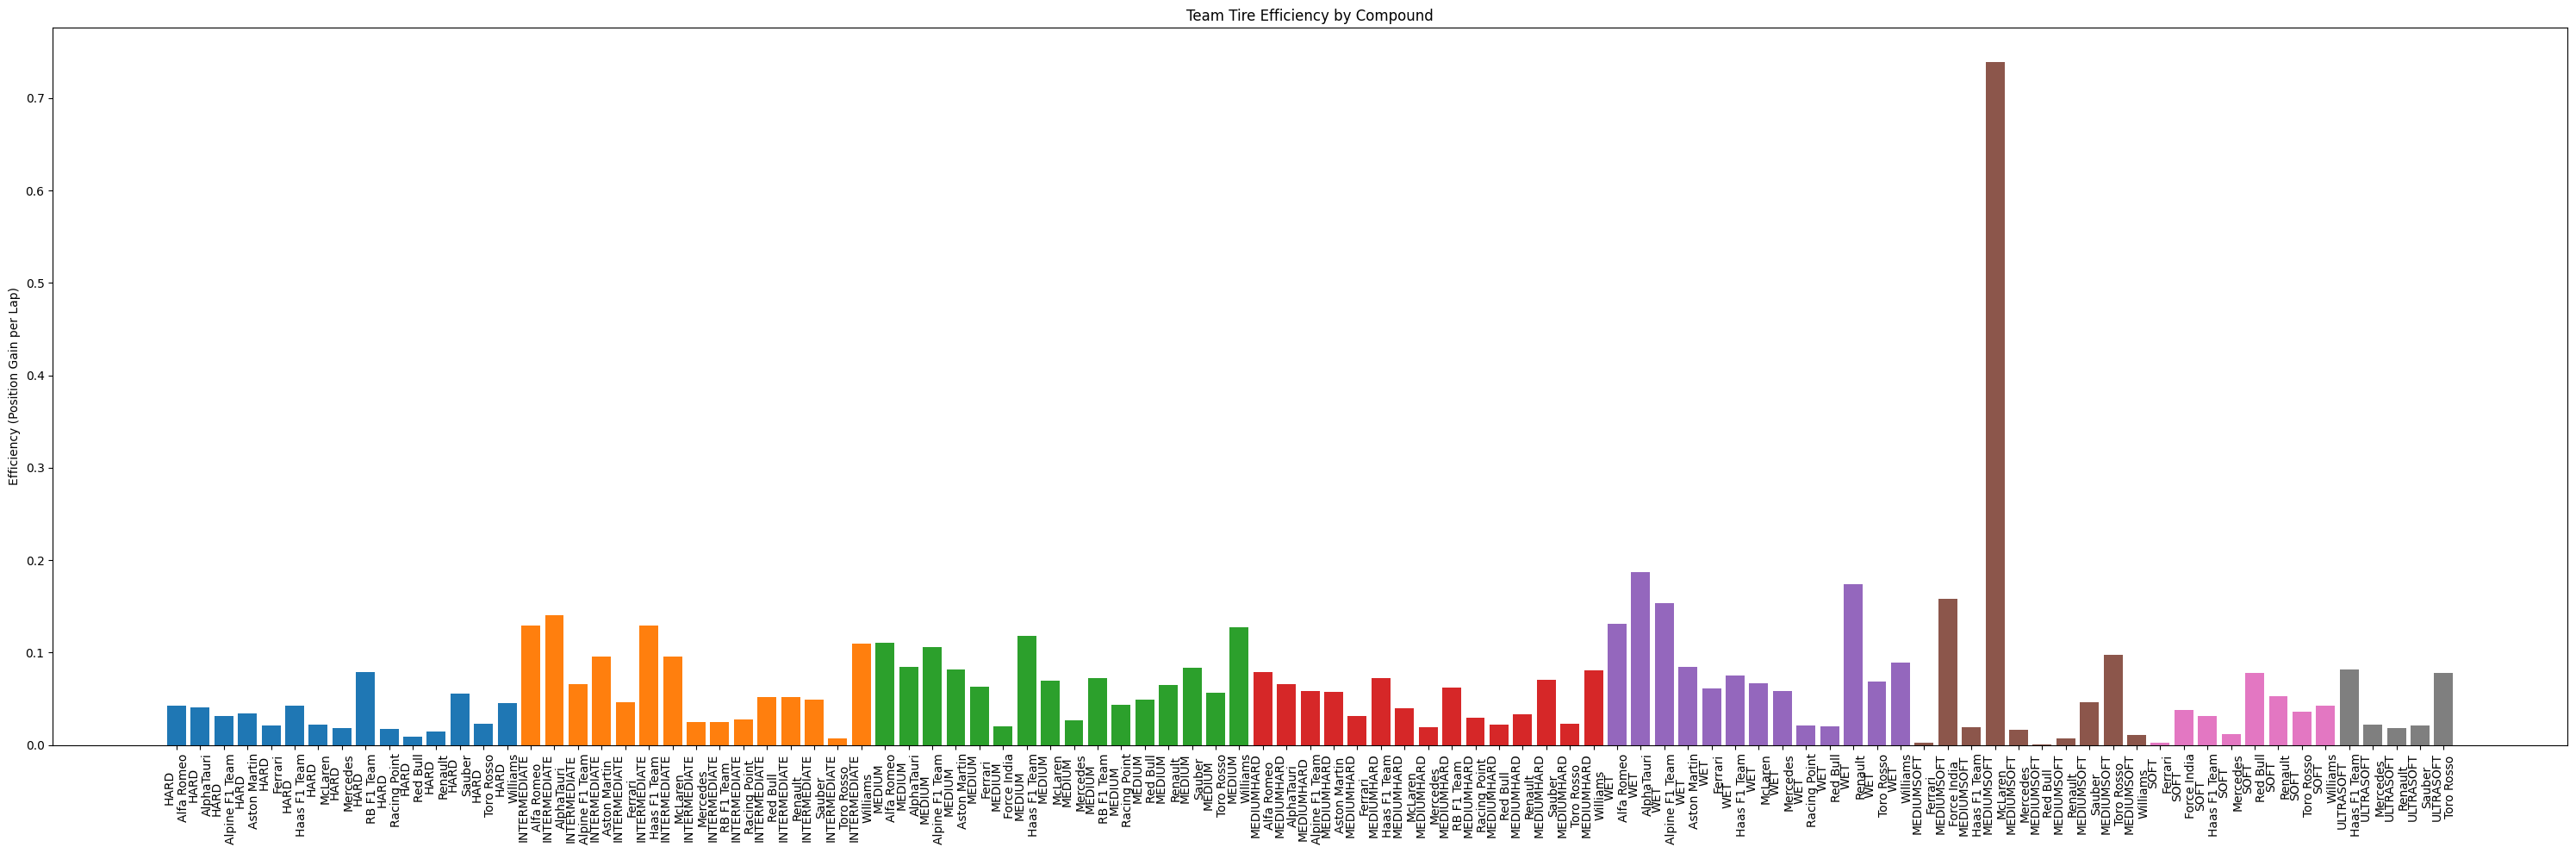

In [276]:
plt.figure(figsize=(30,10))

for compound in team_tire_profile["tire_compound"].unique():
    subset = team_tire_profile[team_tire_profile["tire_compound"] == compound]
    plt.bar(
        [f"{compound}\n{t}" for t in subset["constructor"]],
        subset["avg_efficiency"]
    )

plt.xticks(rotation=90)
plt.ylabel("Efficiency (Position Gain per Lap)")
plt.title("Team Tire Efficiency by Compound")
plt.tight_layout()
plt.show()

On Race Level:Who Won , Number of Stints ,Tire Usage Techniques per winner per race

In [277]:
race_winners = (
    df[df["position"] == 1]
    .groupby(["season", "round"])[["driver", "constructor"]]
    .first()
    .reset_index()
)

race_winners.head(10)

season  round           driver constructor
0    2018     18   Kimi Raikkönen     Ferrari
1    2018     19   Max Verstappen    Red Bull
2    2019      1  Valtteri Bottas    Mercedes
3    2019      2   Lewis Hamilton    Mercedes
4    2019      3   Lewis Hamilton    Mercedes
5    2019      4  Valtteri Bottas    Mercedes
6    2019      5   Lewis Hamilton    Mercedes
7    2019      6   Lewis Hamilton    Mercedes
8    2019      7   Lewis Hamilton    Mercedes
9    2019      8   Lewis Hamilton    Mercedes

season  round           driver constructor
0    2018     18   Kimi Raikkönen     Ferrari
1    2018     19   Max Verstappen    Red Bull
2    2019      1  Valtteri Bottas    Mercedes
3    2019      2   Lewis Hamilton    Mercedes
4    2019      3   Lewis Hamilton    Mercedes
5    2019      4  Valtteri Bottas    Mercedes
6    2019      5   Lewis Hamilton    Mercedes
7    2019      6   Lewis Hamilton    Mercedes
8    2019      7   Lewis Hamilton    Mercedes
9    2019      8   Lewis Hamilton    Mercedes

In [278]:
stints_per_driver = (
    df.groupby(["season", "round", "driver"])["stint"]
    .nunique()
    .reset_index(name="num_stints")
)

stints_per_driver.head(10)

season  round           driver  num_stints
0    2018      1  Kevin Magnussen           1
1    2018      1  Marcus Ericsson           1
2    2018      1     Pierre Gasly           1
3    2018      1  Romain Grosjean           1
4    2018      4  Nico Hülkenberg           1
5    2018      8     Sergio Pérez           1
6    2018      9  Brendon Hartley           1
7    2018      9  Nico Hülkenberg           1
8    2018      9  Valtteri Bottas           1
9    2018     10  Charles Leclerc           1

season  round           driver  num_stints
0    2018      1  Kevin Magnussen           1
1    2018      1  Marcus Ericsson           1
2    2018      1     Pierre Gasly           1
3    2018      1  Romain Grosjean           1
4    2018      4  Nico Hülkenberg           1
5    2018      8     Sergio Pérez           1
6    2018      9  Brendon Hartley           1
7    2018      9  Nico Hülkenberg           1
8    2018      9  Valtteri Bottas           1
9    2018     10  Charles Leclerc           1

Tire usuage per every driver and per winner per race.

In [279]:
tyre_usage = (
    df.groupby(["season", "round", "driver", "tire_compound"])
    .agg(
        stints_with_compound=("stint", "nunique"),
        total_laps_on_compound=("stint_length", "sum")
    )
    .reset_index()
)

tyre_usage.head()

season  round           driver tire_compound  stints_with_compound  \
0    2018      1  Kevin Magnussen          SOFT                     1   
1    2018      1  Marcus Ericsson    MEDIUMSOFT                     1   
2    2018      1     Pierre Gasly          SOFT                     1   
3    2018      1  Romain Grosjean          SOFT                     1   
4    2018      4  Nico Hülkenberg          SOFT                     1   

   total_laps_on_compound  
0                      21  
1                       5  
2                      13  
3                      23  
4                      10

season  round           driver tire_compound  stints_with_compound  \
0    2018      1  Kevin Magnussen          SOFT                     1   
1    2018      1  Marcus Ericsson    MEDIUMSOFT                     1   
2    2018      1     Pierre Gasly          SOFT                     1   
3    2018      1  Romain Grosjean          SOFT                     1   
4    2018      4  Nico Hülkenberg          SOFT                     1   

   total_laps_on_compound  
0                      21  
1                       5  
2                      13  
3                      23  
4                      10

In [280]:
winner_tyre_usage = (
    race_winners
    .merge(tyre_usage, on=["season", "round", "driver"], how="left")
    .sort_values(["season", "round"])
)

winner_tyre_usage.head()

season  round           driver constructor tire_compound  \
0    2018     18   Kimi Raikkönen     Ferrari        MEDIUM   
1    2018     18   Kimi Raikkönen     Ferrari          SOFT   
2    2018     19   Max Verstappen    Red Bull    MEDIUMSOFT   
3    2018     19   Max Verstappen    Red Bull          SOFT   
4    2019      1  Valtteri Bottas    Mercedes        MEDIUM   

   stints_with_compound  total_laps_on_compound  
0                     1                      35  
1                     1                      21  
2                     2                      58  
3                     1                      13  
4                     1                      23

season  round           driver constructor tire_compound  \
0    2018     18   Kimi Raikkönen     Ferrari        MEDIUM   
1    2018     18   Kimi Raikkönen     Ferrari          SOFT   
2    2018     19   Max Verstappen    Red Bull    MEDIUMSOFT   
3    2018     19   Max Verstappen    Red Bull          SOFT   
4    2019      1  Valtteri Bottas    Mercedes        MEDIUM   

   stints_with_compound  total_laps_on_compound  
0                     1                      35  
1                     1                      21  
2                     2                      58  
3                     1                      13  
4                     1                      23

On season Level: Who won , Number of Points , Tire Usage Techniques per winner per season.

In [281]:
season_points = (
    df.groupby(["season", "driver"])["points"]
    .sum()
    .reset_index()
)

season_winner = (
    season_points.sort_values(["season", "points"], ascending=[True, False])
    .groupby("season")
    .first()
    .reset_index()
)

season_winner.head(7)

season          driver  points
0    2018  Max Verstappen     111
1    2019  Lewis Hamilton     782
2    2020  Lewis Hamilton     933
3    2021  Lewis Hamilton    1028
4    2022  Max Verstappen    1061
5    2023  Max Verstappen    1544
6    2024  Max Verstappen    1021

season          driver  points
0    2018  Max Verstappen     111
1    2019  Lewis Hamilton     782
2    2020  Lewis Hamilton     933
3    2021  Lewis Hamilton    1028
4    2022  Max Verstappen    1061
5    2023  Max Verstappen    1544
6    2024  Max Verstappen    1021

In [282]:
tyre_usage = (
    df.groupby(["season", "driver", "tire_compound"])
    .agg(
        stints_with_compound=("stint", "nunique"),
        total_laps_on_compound=("stint_length", "sum")
    )
    .reset_index()
)
season_winner_tyre_usage = (
    season_winner[["season", "driver"]]
    .merge(tyre_usage, on=["season", "driver"], how="left")
    .sort_values("season")
)

season_winner_tyre_usage.head(25)

season          driver tire_compound  stints_with_compound  \
0     2018  Max Verstappen        MEDIUM                     1   
1     2018  Max Verstappen    MEDIUMSOFT                     2   
2     2018  Max Verstappen          SOFT                     1   
3     2019  Lewis Hamilton          HARD                     1   
4     2019  Lewis Hamilton  INTERMEDIATE                     2   
5     2019  Lewis Hamilton        MEDIUM                     6   
6     2019  Lewis Hamilton    MEDIUMHARD                     3   
7     2019  Lewis Hamilton           WET                     1   
8     2020  Lewis Hamilton          HARD                     3   
9     2020  Lewis Hamilton  INTERMEDIATE                     2   
10    2020  Lewis Hamilton        MEDIUM                     5   
11    2020  Lewis Hamilton    MEDIUMHARD                     4   
12    2020  Lewis Hamilton           WET                     1   
13    2021  Lewis Hamilton          HARD                     4   
14    2021  Lewis Hamilton  INTERMEDIATE                     3   
15    2021  Lewis Hamilton        MEDIUM                     3   
16    2021  Lewis Hamilton    MEDIUMHARD                     5   
17    2022  Max Verstappen          HARD                     3   
18    2022  Max Verstappen  INTERMEDIATE                     1   
19    2022  Max Verstappen        MEDIUM                     5   
20    2022  Max Verstappen    MEDIUMHARD                     4   
21    2023  Max Verstappen          HARD                     4   
22    2023  Max Verstappen  INTERMEDIATE                     3   
23    2023  Max Verstappen        MEDIUM                     5   
24    2023  Max Verstappen    MEDIUMHARD                     4   

    total_laps_on_compound  
0                       22  
1                       92  
2                       18  
3                      273  
4                       43  
5                      234  
6                      461  
7                        3  
8                      275  
9                       53  
10                     154  
11                     323  
12                       8  
13                     471  
14                      94  
15                     106  
16                     399  
17                     280  
18                      54  
19                     235  
20                     430  
21                     517  
22                      42  
23                     154  
24                     489

season          driver tire_compound  stints_with_compound  \
0     2018  Max Verstappen        MEDIUM                     1   
1     2018  Max Verstappen    MEDIUMSOFT                     2   
2     2018  Max Verstappen          SOFT                     1   
3     2019  Lewis Hamilton          HARD                     1   
4     2019  Lewis Hamilton  INTERMEDIATE                     2   
5     2019  Lewis Hamilton        MEDIUM                     6   
6     2019  Lewis Hamilton    MEDIUMHARD                     3   
7     2019  Lewis Hamilton           WET                     1   
8     2020  Lewis Hamilton          HARD                     3   
9     2020  Lewis Hamilton  INTERMEDIATE                     2   
10    2020  Lewis Hamilton        MEDIUM                     5   
11    2020  Lewis Hamilton    MEDIUMHARD                     4   
12    2020  Lewis Hamilton           WET                     1   
13    2021  Lewis Hamilton          HARD                     4   
14    2021  Lewis Hamilton  INTERMEDIATE                     3   
15    2021  Lewis Hamilton        MEDIUM                     3   
16    2021  Lewis Hamilton    MEDIUMHARD                     5   
17    2022  Max Verstappen          HARD                     3   
18    2022  Max Verstappen  INTERMEDIATE                     1   
19    2022  Max Verstappen        MEDIUM                     5   
20    2022  Max Verstappen    MEDIUMHARD                     4   
21    2023  Max Verstappen          HARD                     4   
22    2023  Max Verstappen  INTERMEDIATE                     3   
23    2023  Max Verstappen        MEDIUM                     5   
24    2023  Max Verstappen    MEDIUMHARD                     4   

    total_laps_on_compound  
0                       22  
1                       92  
2                       18  
3                      273  
4                       43  
5                      234  
6                      461  
7                        3  
8                      275  
9                       53  
10                     154  
11                     323  
12                       8  
13                     471  
14                      94  
15                     106  
16                     399  
17                     280  
18                      54  
19                     235  
20                     430  
21                     517  
22                      42  
23                     154  
24                     489

In [283]:
winner_tyre_usage = (
    season_winner[["season", "driver"]]
    .merge(tyre_usage, on=["season", "driver"], how="left")
)

In [284]:
most_used_compound = (
    winner_tyre_usage.sort_values(["season", "total_laps_on_compound"], ascending=[True, False])
    .groupby("season")
    .first()
    .reset_index()
)

most_used_compound[["season", "driver", "tire_compound", "total_laps_on_compound"]]


season          driver tire_compound  total_laps_on_compound
0    2018  Max Verstappen    MEDIUMSOFT                      92
1    2019  Lewis Hamilton    MEDIUMHARD                     461
2    2020  Lewis Hamilton    MEDIUMHARD                     323
3    2021  Lewis Hamilton          HARD                     471
4    2022  Max Verstappen    MEDIUMHARD                     430
5    2023  Max Verstappen          HARD                     517
6    2024  Max Verstappen          HARD                     608

season          driver tire_compound  total_laps_on_compound
0    2018  Max Verstappen    MEDIUMSOFT                      92
1    2019  Lewis Hamilton    MEDIUMHARD                     461
2    2020  Lewis Hamilton    MEDIUMHARD                     323
3    2021  Lewis Hamilton          HARD                     471
4    2022  Max Verstappen    MEDIUMHARD                     430
5    2023  Max Verstappen          HARD                     517
6    2024  Max Verstappen          HARD                     608

- Driver evaluation depending on driver aggression score, final position and position changing rate


In [285]:

# --- Final Position ---
final_positions = (
    df.groupby(["season", "round", "driver"])["position"]
    .min()
    .reset_index()
    .rename(columns={"position": "final_position"})
)

# --- Position Change Rate ---
df["position_change"] = df["position_changes"]
df["position_change_rate"] = df["position_change"] / df["laps"]

position_change_rate = (
    df.groupby(["season", "round", "driver"])["position_change_rate"]
    .mean()
    .reset_index()
)

# --- Aggression Score ---
# If you already have the column: df["aggression_score"]
# If not, placeholder for demonstration:
df["aggression_score"] = df["driver_aggression_score"]

aggression_scores = (
    df.groupby(["season", "round", "driver"])["aggression_score"]
    .mean()
    .reset_index()
)

# --- Combine all metrics ---
driver_eval = (
    final_positions
    .merge(position_change_rate, on=["season", "round", "driver"])
    .merge(aggression_scores, on=["season", "round", "driver"])
)

# --- Normalize metrics ---
driver_eval["aggression_norm"] = driver_eval["aggression_score"] / driver_eval["aggression_score"].max()
driver_eval["pos_change_norm"] = (driver_eval["position_change_rate"] - driver_eval["position_change_rate"].min()) / (driver_eval["position_change_rate"].max() - driver_eval["position_change_rate"].min())
driver_eval["final_pos_norm"] = (driver_eval["final_position"] - driver_eval["final_position"].min()) / (driver_eval["final_position"].max() - driver_eval["final_position"].min())

# --- Final Driver Evaluation Score ---
driver_eval["driver_evaluation_score"] = (
    0.3 * driver_eval["aggression_norm"] +
    0.3 * driver_eval["pos_change_norm"] +
    0.4 * (1 - driver_eval["final_pos_norm"])
)

driver_eval.sort_values("driver_evaluation_score", ascending=False).head()


season  round           driver  final_position  position_change_rate  \
1800    2024      8  Charles Leclerc               1              0.000000   
1805    2024      8    Oscar Piastri               2              0.000557   
1799    2024      8     Carlos Sainz               3              0.001115   
1804    2024      8     Lando Norris               4              0.001672   
1803    2024      8   George Russell               5              0.002230   

      aggression_score  aggression_norm  pos_change_norm  final_pos_norm  \
1800        343.989934         0.766480         0.000000        0.000000   
1805        343.937095         0.766362         0.000675        0.052632   
1799        339.352474         0.756147         0.001350        0.105263   
1804        345.130519         0.769022         0.002024        0.157895   
1803        345.708995         0.770311         0.002699        0.210526   

      driver_evaluation_score  
1800                 0.629944  
1805                 0.609059  
1799                 0.585144  
1804                 0.568156  
1803                 0.547692

season  round           driver  final_position  position_change_rate  \
1800    2024      8  Charles Leclerc               1              0.000000   
1805    2024      8    Oscar Piastri               2              0.000557   
1799    2024      8     Carlos Sainz               3              0.001115   
1804    2024      8     Lando Norris               4              0.001672   
1803    2024      8   George Russell               5              0.002230   

      aggression_score  aggression_norm  pos_change_norm  final_pos_norm  \
1800        343.989934         0.766480         0.000000        0.000000   
1805        343.937095         0.766362         0.000675        0.052632   
1799        339.352474         0.756147         0.001350        0.105263   
1804        345.130519         0.769022         0.002024        0.157895   
1803        345.708995         0.770311         0.002699        0.210526   

      driver_evaluation_score  
1800                 0.629944  
1805                 0.609059  
1799                 0.585144  
1804                 0.568156  
1803                 0.547692

- Circuits with most pitstops

In [286]:
pitstops_per_circuit = (
    df.groupby("circuit")["totalpitstops"]
    .sum()
    .reset_index()
    .sort_values("totalpitstops", ascending=False)
)

pitstops_per_circuit.head(10)


circuit  totalpitstops
7    Bahrain International Circuit           1078
10          Circuit Park Zandvoort           1059
17                     Hungaroring            810
27             Silverstone Circuit            805
12  Circuit de Barcelona-Catalunya            786
25                   Red Bull Ring            634
21    Losail International Circuit            530
15         Circuit of the Americas            512
29                  Suzuka Circuit            504
1    Autodromo Enzo e Dino Ferrari            466

circuit  totalpitstops
7    Bahrain International Circuit           1078
10          Circuit Park Zandvoort           1059
17                     Hungaroring            810
27             Silverstone Circuit            805
12  Circuit de Barcelona-Catalunya            786
25                   Red Bull Ring            634
21    Losail International Circuit            530
15         Circuit of the Americas            512
29                  Suzuka Circuit            504
1    Autodromo Enzo e Dino Ferrari            466

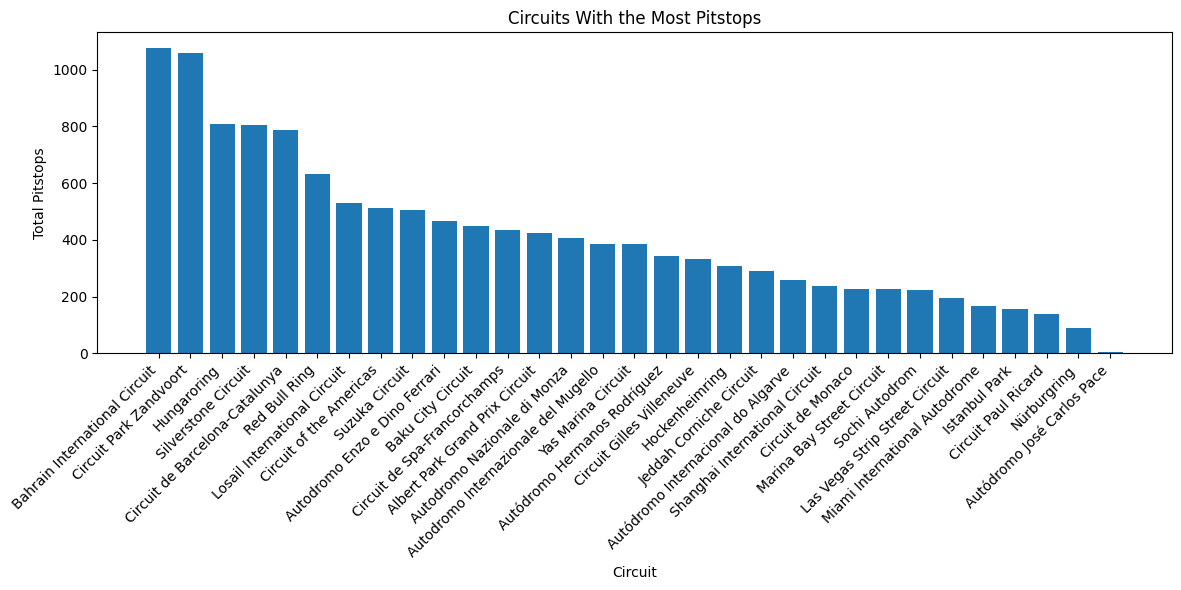

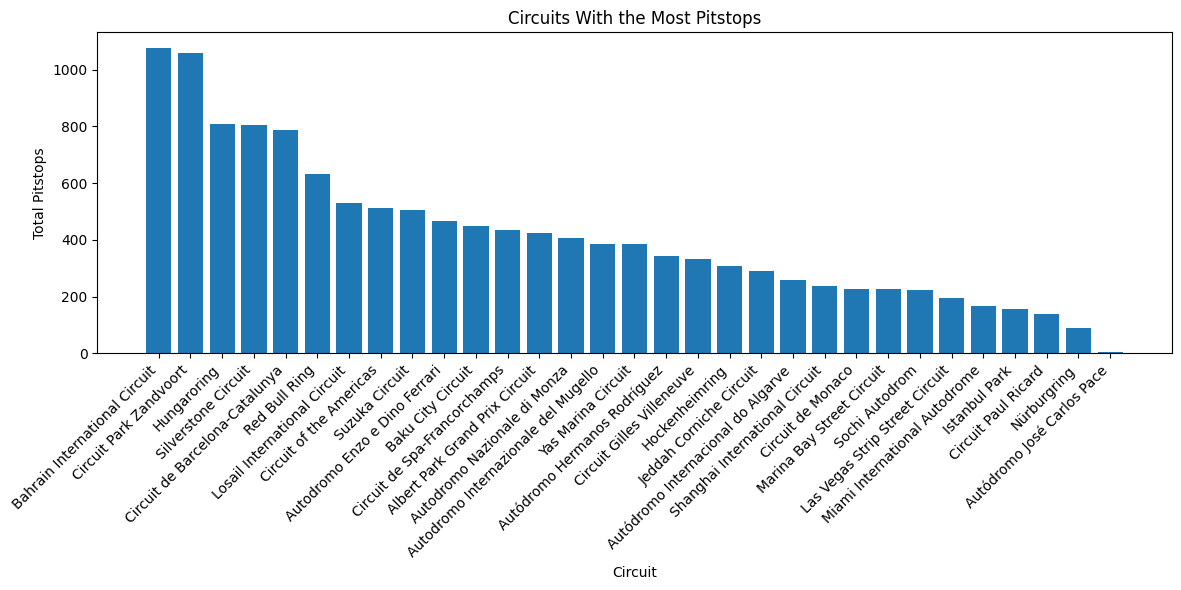

In [287]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,6))

plt.bar(
    pitstops_per_circuit["circuit"],
    pitstops_per_circuit["totalpitstops"]
)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Circuit")
plt.ylabel("Total Pitstops")
plt.title("Circuits With the Most Pitstops")
plt.tight_layout()
plt.show()

Per Season.

In [288]:
pitstops_per_circuit_season = (
    df.groupby(["season", "circuit"])["totalpitstops"]
    .sum()
    .reset_index()
    .sort_values(["season", "totalpitstops"], ascending=[True, False])
)

pitstops_per_circuit_season.head(10)

season                         circuit  totalpitstops
1     2018    Autódromo Hermanos Rodríguez             72
4     2018         Circuit of the Americas             34
0     2018  Albert Park Grand Prix Circuit              2
8     2018             Silverstone Circuit              1
2     2018               Baku City Circuit              0
3     2018             Circuit Paul Ricard              0
5     2018                  Hockenheimring              0
6     2018                     Hungaroring              0
7     2018                   Red Bull Ring              0
20    2019                  Hockenheimring            309

season                         circuit  totalpitstops
1     2018    Autódromo Hermanos Rodríguez             72
4     2018         Circuit of the Americas             34
0     2018  Albert Park Grand Prix Circuit              2
8     2018             Silverstone Circuit              1
2     2018               Baku City Circuit              0
3     2018             Circuit Paul Ricard              0
5     2018                  Hockenheimring              0
6     2018                     Hungaroring              0
7     2018                   Red Bull Ring              0
20    2019                  Hockenheimring            309

Linking the Constructor, The Driver and the race participation to evaluate overall performance.

In [289]:
df["race_key"] = df["season"].astype(str) + "-" + df["round"].astype(str)
driver_race = df.groupby(["season", "round", "driver", "constructor"]).size().reset_index()


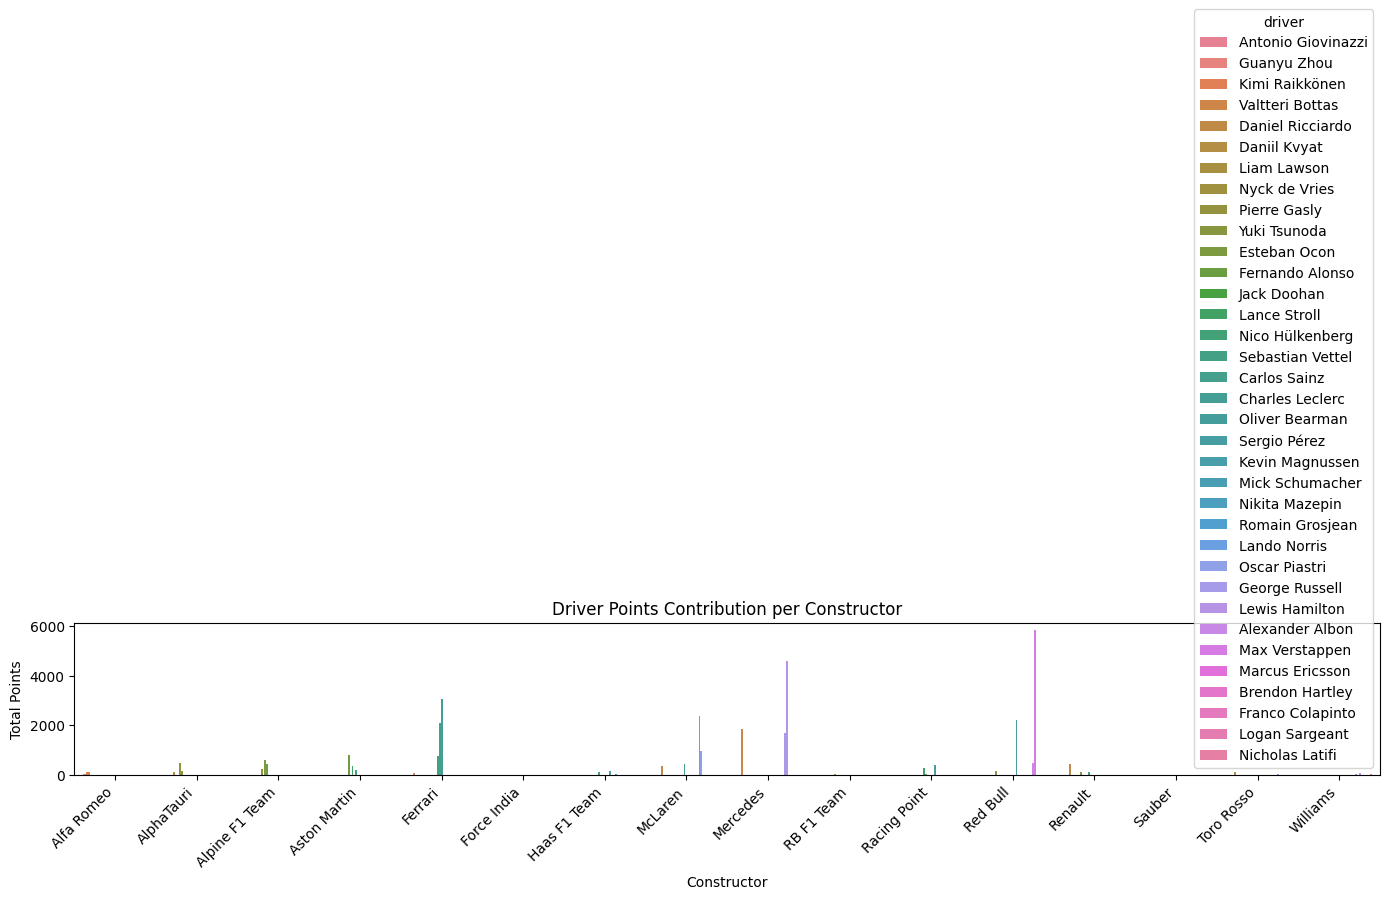

season          driver  season_points  avg_finish_position  avg_aggression
0    2018  Max Verstappen            111             7.333333        6.626024
1    2019  Lewis Hamilton            782             2.235294        6.251617
2    2020  Lewis Hamilton            933             1.785714       18.644454
3    2021  Lewis Hamilton           1028             3.777778       28.717860
4    2022  Max Verstappen           1061             2.764706       12.393123
5    2023  Max Verstappen           1544             1.300000       19.526735
6    2024  Max Verstappen           1021             2.904762        9.346310

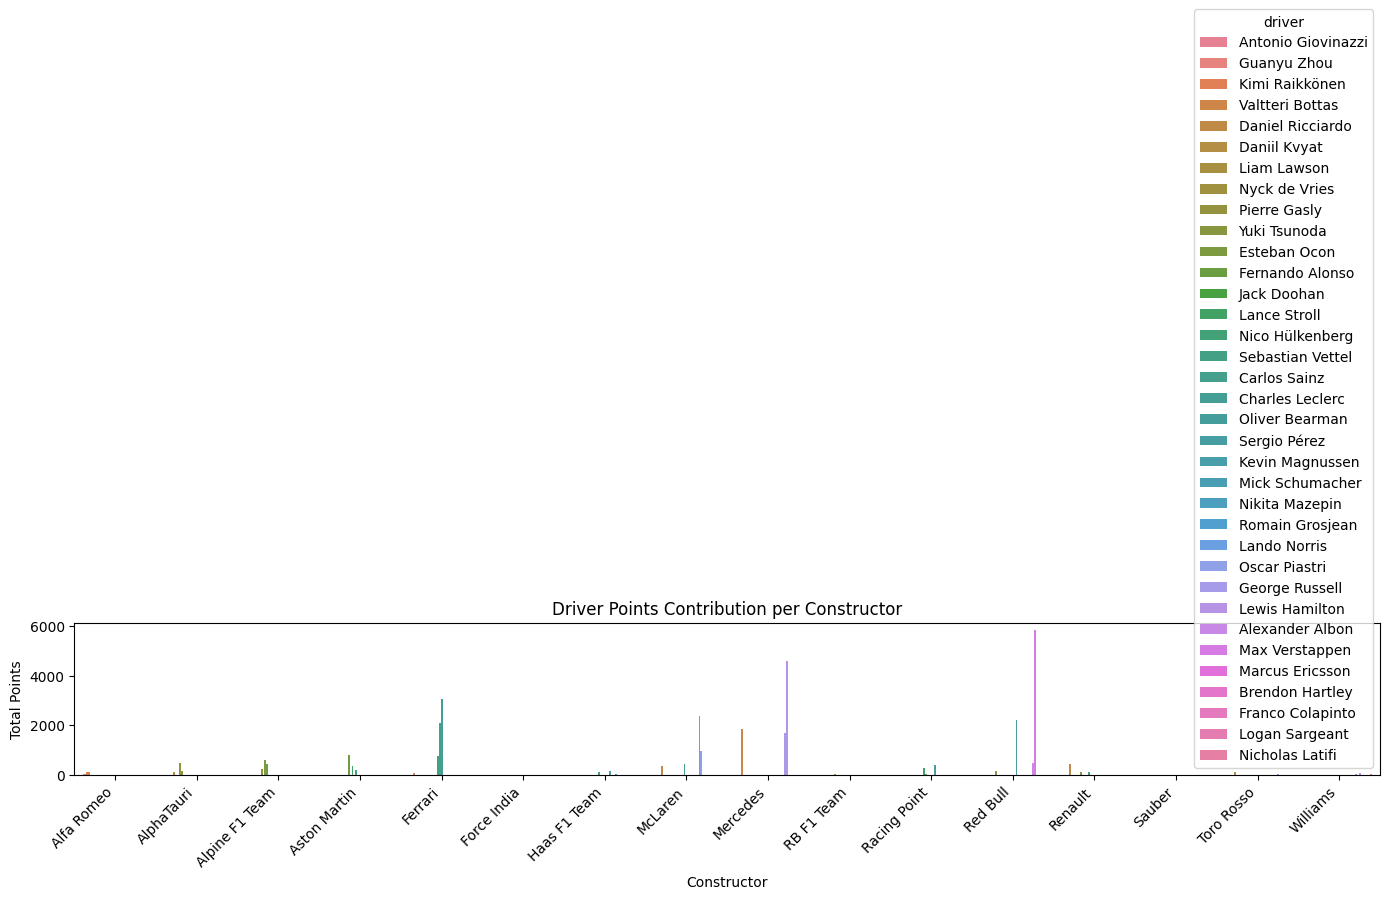

season          driver  season_points  avg_finish_position  avg_aggression
0    2018  Max Verstappen            111             7.333333        6.626024
1    2019  Lewis Hamilton            782             2.235294        6.251617
2    2020  Lewis Hamilton            933             1.785714       18.644454
3    2021  Lewis Hamilton           1028             3.777778       28.717860
4    2022  Max Verstappen           1061             2.764706       12.393123
5    2023  Max Verstappen           1544             1.300000       19.526735
6    2024  Max Verstappen           1021             2.904762        9.346310

In [290]:
import seaborn as sns

# -------------------------------
# 1. Driver Race Results
# -------------------------------
driver_results = (
    df.groupby(["season", "round", "driver", "constructor"])
    .agg(
        final_position=("position", "min"),
        points=("points", "sum"),
        total_pitstops=("totalpitstops", "sum"),
        total_laps=("laps", "sum")
    )
    .reset_index()
)

# -------------------------------
# 2. Driver Aggression / Position Change
# -------------------------------
# Calculate position change per race
df["position_change"] = df["position_changes"]
df["position_change_rate"] = df["position_change"] / df["laps"]

driver_metrics = (
    df.groupby(["season", "round", "driver", "constructor"])
    .agg(
        avg_position_change_rate=("position_change_rate", "mean"),
        avg_stint_length=("stint_length", "mean"),
        aggression_score=("driver_aggression_score", "mean")
    )
    .reset_index()
)

# Merge driver results with metrics
driver_eval = driver_results.merge(driver_metrics, on=["season", "round", "driver", "constructor"])

# -------------------------------
# 3. Constructor Performance
# -------------------------------
constructor_eval = (
    driver_eval.groupby(["season", "constructor"])
    .agg(
        total_points=("points", "sum"),
        avg_finish_position=("final_position", "mean"),
        total_pitstops=("total_pitstops", "sum")
    )
    .reset_index()
)

# -------------------------------
# 4. Race-Level Summary
# -------------------------------
race_summary = (
    driver_eval.groupby(["season", "round"])
    .agg(
        winner=("driver", lambda x: x.iloc[x.argmin()]),
        winning_constructor=("constructor", lambda x: x.iloc[x.argmin()]),
        max_points=("points", "max"),
        avg_stint_length=("avg_stint_length", "mean"),
        total_pitstops=("total_pitstops", "sum")
    )
    .reset_index()
)

# -------------------------------
# 5. Season-Level Summary
# -------------------------------
season_summary = (
    driver_eval.groupby(["season", "driver"])
    .agg(
        season_points=("points", "sum"),
        avg_finish_position=("final_position", "mean"),
        avg_aggression=("aggression_score", "mean")
    )
    .reset_index()
)

season_winners = (
    season_summary.sort_values(["season", "season_points"], ascending=[True, False])
    .groupby("season")
    .first()
    .reset_index()
)

# -------------------------------
# 6. Visualizations
# -------------------------------

# Top Drivers per Constructor (Total Points)
plt.figure(figsize=(14,6))
driver_points = driver_eval.groupby(["constructor", "driver"])["points"].sum().reset_index()
sns.barplot(data=driver_points, x="constructor", y="points", hue="driver", dodge=True)
plt.xticks(rotation=45, ha='right')
plt.title("Driver Points Contribution per Constructor")
plt.ylabel("Total Points")
plt.xlabel("Constructor")
plt.tight_layout()
plt.show()

# -------------------------------
# 7. Output Summary Tables
# -------------------------------
# Driver evaluation table
driver_eval.sort_values("points", ascending=False).head()

# Constructor evaluation table
constructor_eval.sort_values("total_points", ascending=False).head()

# Race summary table
race_summary.head()

# Season winners table
season_winners


 How many laps can each tire compound typically withstand, and what factors influence tire longevity?


/tmp/ipython-input-327047836.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=compound_laps, x="tire_compound", y="avg_laps", palette="viridis")


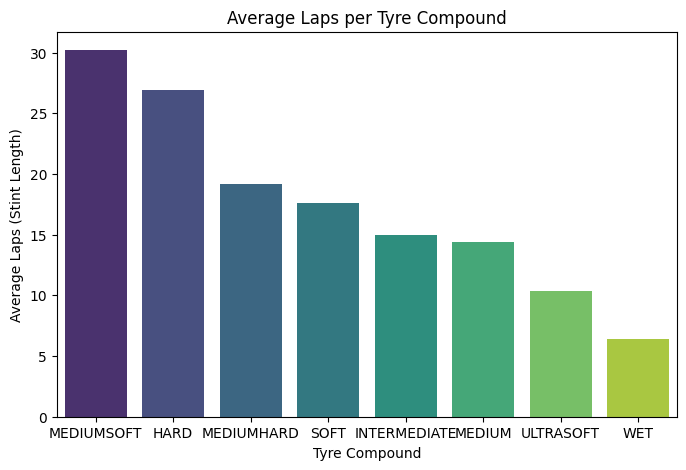

/tmp/ipython-input-327047836.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=compound_laps, x="tire_compound", y="avg_laps", palette="viridis")


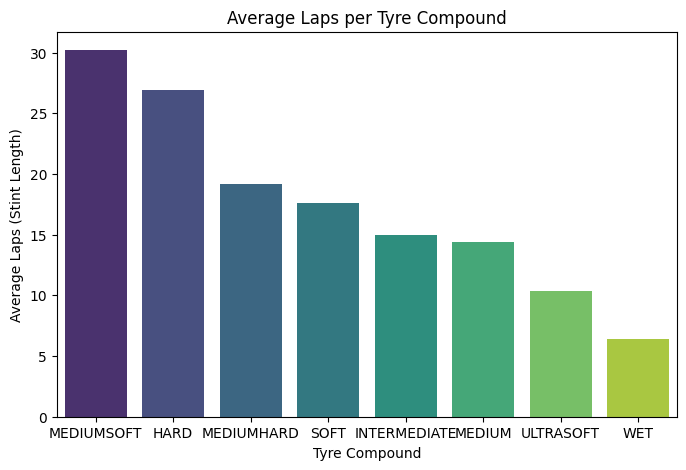

In [291]:

compound_laps = (
    df.groupby("tire_compound")["stint_length"]
    .mean()
    .reset_index()
    .rename(columns={"stint_length": "avg_laps"})
    .sort_values("avg_laps", ascending=False)
)

compound_laps
# Average laps per compound per season
compound_laps_season = (
    df.groupby(["season", "tire_compound"])["stint_length"]
    .mean()
    .reset_index()
    .rename(columns={"stint_length": "avg_laps"})
    .sort_values(["season", "avg_laps"], ascending=[True, False])
)

# Average laps per compound per circuit
compound_laps_circuit = (
    df.groupby(["circuit", "tire_compound"])["stint_length"]
    .mean()
    .reset_index()
    .rename(columns={"stint_length": "avg_laps"})
    .sort_values(["circuit", "avg_laps"], ascending=[True, False])
)

plt.figure(figsize=(8,5))
sns.barplot(data=compound_laps, x="tire_compound", y="avg_laps", palette="viridis")
plt.title("Average Laps per Tyre Compound")
plt.xlabel("Tyre Compound")
plt.ylabel("Average Laps (Stint Length)")
plt.show()


What tire compound should be used under different conditions, and why? Also, what tire types are recommended for each track depending on weather and track characteristics?



In [292]:

# Group by circuit and compound
track_tyre_usage = (
    df.groupby(["race_name", "tire_compound"])
    .agg(
        avg_laps=("stint_length", "mean"),
        total_stints=("stint", "nunique"),
        top_driver_usage=("driver", lambda x: x.value_counts().index[0])  # most frequent driver using this compound
    )
    .reset_index()
    .sort_values(["race_name", "avg_laps"], ascending=[True, False])
)

track_tyre_usage.head(10)


race_name tire_compound   avg_laps  total_stints  \
0   70th Anniversary Grand Prix          HARD  19.600000             3   
2   70th Anniversary Grand Prix    MEDIUMHARD  13.240000             4   
1   70th Anniversary Grand Prix        MEDIUM   8.000000             1   
3          Abu Dhabi Grand Prix          HARD  28.601695             3   
5          Abu Dhabi Grand Prix    MEDIUMHARD  16.741573             3   
4          Abu Dhabi Grand Prix        MEDIUM  10.923077             4   
6         Australian Grand Prix          HARD  29.181818             4   
10        Australian Grand Prix          SOFT  19.000000             1   
8         Australian Grand Prix    MEDIUMHARD  18.132075             3   
7         Australian Grand Prix        MEDIUM   6.395833             7   

    top_driver_usage  
0    Alexander Albon  
2   Daniel Ricciardo  
1    Nico Hülkenberg  
3       Carlos Sainz  
5     George Russell  
4       Pierre Gasly  
6       Lance Stroll  
10   Kevin Magnussen  
8       Lance Stroll  
7    Valtteri Bottas

race_name tire_compound   avg_laps  total_stints  \
0   70th Anniversary Grand Prix          HARD  19.600000             3   
2   70th Anniversary Grand Prix    MEDIUMHARD  13.240000             4   
1   70th Anniversary Grand Prix        MEDIUM   8.000000             1   
3          Abu Dhabi Grand Prix          HARD  28.601695             3   
5          Abu Dhabi Grand Prix    MEDIUMHARD  16.741573             3   
4          Abu Dhabi Grand Prix        MEDIUM  10.923077             4   
6         Australian Grand Prix          HARD  29.181818             4   
10        Australian Grand Prix          SOFT  19.000000             1   
8         Australian Grand Prix    MEDIUMHARD  18.132075             3   
7         Australian Grand Prix        MEDIUM   6.395833             7   

    top_driver_usage  
0    Alexander Albon  
2   Daniel Ricciardo  
1    Nico Hülkenberg  
3       Carlos Sainz  
5     George Russell  
4       Pierre Gasly  
6       Lance Stroll  
10   Kevin Magnussen  
8       Lance Stroll  
7    Valtteri Bottas

In [293]:
# Select the compound with maximum average laps per track (longest-lasting / typical race compound)
recommended_tyre_per_track = (
    track_tyre_usage.sort_values(["race_name", "avg_laps"], ascending=[True, False])
    .groupby("race_name")
    .first()
    .reset_index()
)

recommended_tyre_per_track = recommended_tyre_per_track[[
    "race_name", "tire_compound", "avg_laps", "total_stints"
]].rename(columns={
    "race_name": "track_name",
    "tire_compound": "recommended_compound",
    "avg_laps": "avg_laps_on_compound",
    "total_stints": "num_stints_used"
})

recommended_tyre_per_track

track_name recommended_compound  avg_laps_on_compound  \
0   70th Anniversary Grand Prix                 HARD             19.600000   
1          Abu Dhabi Grand Prix                 HARD             28.601695   
2         Australian Grand Prix                 HARD             29.181818   
3           Austrian Grand Prix           MEDIUMSOFT             33.500000   
4         Azerbaijan Grand Prix                 HARD             28.527473   
5            Bahrain Grand Prix                 HARD             19.190083   
6            Belgian Grand Prix                 HARD             21.627119   
7            British Grand Prix                 HARD             25.480000   
8           Canadian Grand Prix                 HARD             33.934211   
9            Chinese Grand Prix                 HARD             22.837209   
10             Dutch Grand Prix                 HARD             30.607843   
11             Eifel Grand Prix                 HARD             25.750000   
12    Emilia Romagna Grand Prix                 HARD             34.272727   
13            French Grand Prix                 HARD             30.963636   
14            German Grand Prix         INTERMEDIATE             15.966667   
15         Hungarian Grand Prix                 HARD             32.046296   
16           Italian Grand Prix                 HARD             23.175000   
17          Japanese Grand Prix                 HARD             18.629630   
18         Las Vegas Grand Prix                 HARD             21.483871   
19           Mexican Grand Prix                 HARD             40.222222   
20       Mexico City Grand Prix           MEDIUMHARD             29.393443   
21             Miami Grand Prix                 HARD             33.818182   
22            Monaco Grand Prix                 HARD             46.250000   
23        Portuguese Grand Prix                 HARD             31.785714   
24             Qatar Grand Prix           MEDIUMHARD             18.743902   
25           Russian Grand Prix                 HARD             30.307692   
26            Sakhir Grand Prix           MEDIUMHARD             30.428571   
27     Saudi Arabian Grand Prix                 HARD             24.864198   
28         Singapore Grand Prix                 HARD             32.000000   
29           Spanish Grand Prix                 HARD             25.731707   
30           Styrian Grand Prix                 HARD             33.739130   
31         São Paulo Grand Prix         INTERMEDIATE             23.000000   
32           Turkish Grand Prix         INTERMEDIATE             26.740260   
33            Tuscan Grand Prix                 HARD             12.375000   
34     United States Grand Prix                 HARD             23.821429   

    num_stints_used  
0                 3  
1                 3  
2                 4  
3                 1  
4                 4  
5                 5  
6                 3  
7                 4  
8                 4  
9                 4  
10                3  
11                1  
12                3  
13                3  
14                4  
15                6  
16                4  
17                3  
18                3  
19                3  
20                4  
21                2  
22                3  
23                2  
24                4  
25                2  
26                4  
27                4  
28                2  
29                3  
30                3  
31                3  
32                4  
33                3  
34                3

track_name recommended_compound  avg_laps_on_compound  \
0   70th Anniversary Grand Prix                 HARD             19.600000   
1          Abu Dhabi Grand Prix                 HARD             28.601695   
2         Australian Grand Prix                 HARD             29.181818   
3           Austrian Grand Prix           MEDIUMSOFT             33.500000   
4         Azerbaijan Grand Prix                 HARD             28.527473   
5            Bahrain Grand Prix                 HARD             19.190083   
6            Belgian Grand Prix                 HARD             21.627119   
7            British Grand Prix                 HARD             25.480000   
8           Canadian Grand Prix                 HARD             33.934211   
9            Chinese Grand Prix                 HARD             22.837209   
10             Dutch Grand Prix                 HARD             30.607843   
11             Eifel Grand Prix                 HARD             25.750000   
12    Emilia Romagna Grand Prix                 HARD             34.272727   
13            French Grand Prix                 HARD             30.963636   
14            German Grand Prix         INTERMEDIATE             15.966667   
15         Hungarian Grand Prix                 HARD             32.046296   
16           Italian Grand Prix                 HARD             23.175000   
17          Japanese Grand Prix                 HARD             18.629630   
18         Las Vegas Grand Prix                 HARD             21.483871   
19           Mexican Grand Prix                 HARD             40.222222   
20       Mexico City Grand Prix           MEDIUMHARD             29.393443   
21             Miami Grand Prix                 HARD             33.818182   
22            Monaco Grand Prix                 HARD             46.250000   
23        Portuguese Grand Prix                 HARD             31.785714   
24             Qatar Grand Prix           MEDIUMHARD             18.743902   
25           Russian Grand Prix                 HARD             30.307692   
26            Sakhir Grand Prix           MEDIUMHARD             30.428571   
27     Saudi Arabian Grand Prix                 HARD             24.864198   
28         Singapore Grand Prix                 HARD             32.000000   
29           Spanish Grand Prix                 HARD             25.731707   
30           Styrian Grand Prix                 HARD             33.739130   
31         São Paulo Grand Prix         INTERMEDIATE             23.000000   
32           Turkish Grand Prix         INTERMEDIATE             26.740260   
33            Tuscan Grand Prix                 HARD             12.375000   
34     United States Grand Prix                 HARD             23.821429   

    num_stints_used  
0                 3  
1                 3  
2                 4  
3                 1  
4                 4  
5                 5  
6                 3  
7                 4  
8                 4  
9                 4  
10                3  
11                1  
12                3  
13                3  
14                4  
15                6  
16                4  
17                3  
18                3  
19                3  
20                4  
21                2  
22                3  
23                2  
24                4  
25                2  
26                4  
27                4  
28                2  
29                3  
30                3  
31                3  
32                4  
33                3  
34                3

In [294]:

# This cell no longer needs to define heatmap_data as it's moved to the plotting cell.
# Aggregate average stint length per compound per circuit
track_compound_laps = (
    df.groupby(["circuit", "tire_compound"])
    .agg(avg_laps=("stint_length", "mean"))
    .reset_index()
)


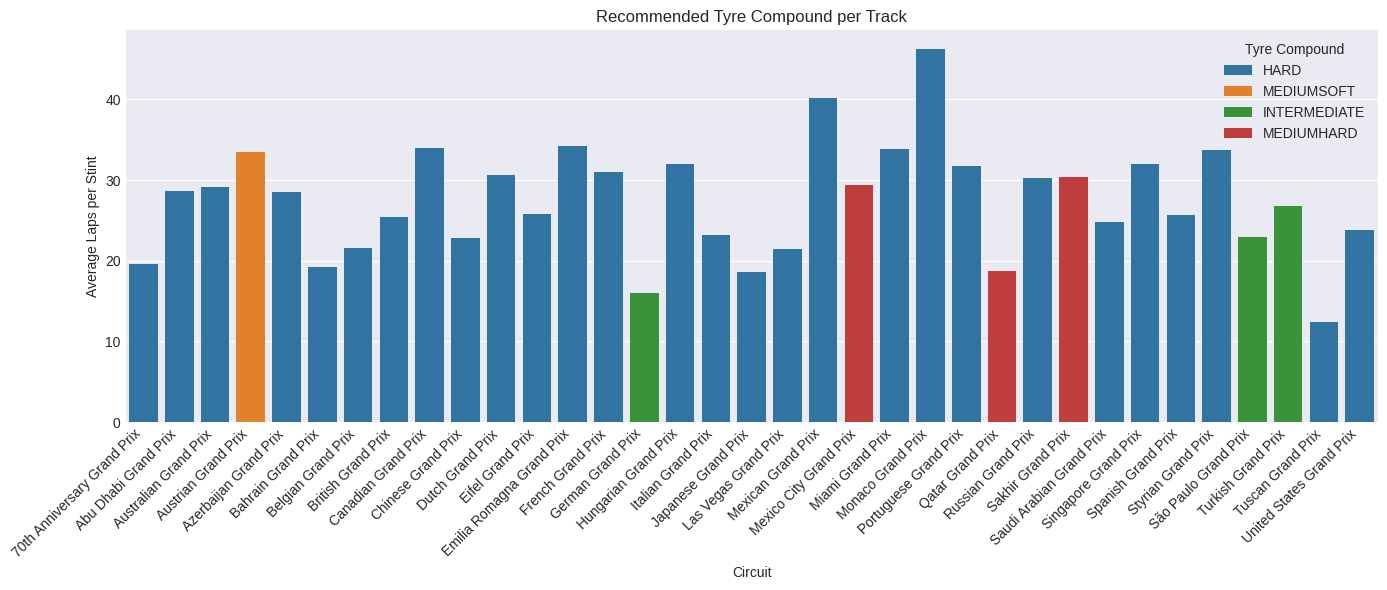

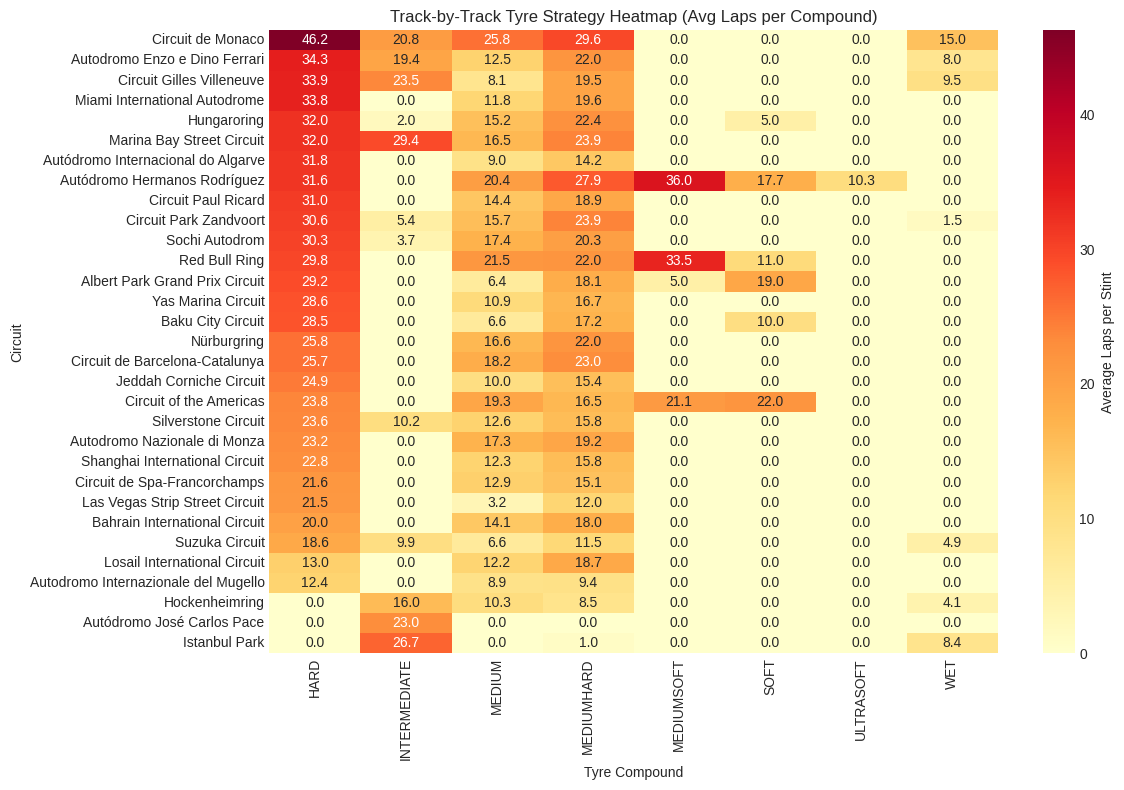

In [305]:

# Aggregate average stint length per compound per circuit
track_compound_laps = (
    df.groupby(["circuit", "compound"]) # Changed 'tire_compound' to 'compound'
    .agg(avg_laps=("stint_length", "mean"))
    .reset_index()
)

# Pivot for heatmap: circuits as rows, compounds as columns
heatmap_data = track_compound_laps.pivot(index="circuit", columns="compound", values="avg_laps").fillna(0) # Changed 'tire_compound' to 'compound'

# Sort circuits for better readability (optional)
# Ensure all columns in 'by' exist before sorting, or handle their absence.
# For now, let's keep the sorting as it was, assuming these columns will be present.
heatmap_data = heatmap_data.sort_values(by=["HARD", "MEDIUM", "SOFT"], ascending=False, axis=0)

plt.figure(figsize=(14,6))
sns.barplot(
    data=recommended_tyre_per_track,
    x="track_name", # Corrected from "circuit" to "track_name"
    y="avg_laps_on_compound",
    hue="recommended_compound",
    dodge=False
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Laps per Stint")
plt.xlabel("Circuit")
plt.title("Recommended Tyre Compound per Track")
plt.legend(title="Tyre Compound")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(
    heatmap_data,
    annot=True,        # show numbers
    fmt=".1f",
    cmap="YlOrRd",     # yellow-orange-red gradient
    cbar_kws={'label': 'Average Laps per Stint'}
)

plt.title("Track-by-Track Tyre Strategy Heatmap (Avg Laps per Compound)")
plt.xlabel("Tyre Compound")
plt.ylabel("Circuit")
plt.tight_layout()
plt.show()


What were the strengths of the top five constructors and the weaknesses of the bottom five? And how important is tire strategy in determining constructor performance?



In [306]:
# Aggregate constructor points per season
constructor_eval = (
    driver_eval.groupby(["constructor"])
    .agg(
        total_points=("points", "sum"),
        avg_finish_position=("final_position", "mean"),
        total_pitstops=("total_pitstops", "sum"),
        avg_stint_length=("avg_stint_length", "mean")
    )
    .reset_index()
    .sort_values("total_points", ascending=False)
)

# Top 5
top5_constructors = constructor_eval.head(5)

# Bottom 5
bottom5_constructors = constructor_eval.tail(5)

In [307]:
top5_constructors[["constructor", "total_points", "avg_finish_position", "total_pitstops", "avg_stint_length"]]

constructor  total_points  avg_finish_position  total_pitstops  \
11      Red Bull          8698             4.596154            1386   
8       Mercedes          8110             4.630841            1349   
4        Ferrari          6008             6.111628            1216   
7        McLaren          4112             7.855140            1306   
3   Aston Martin          1355            10.532895            1006   

    avg_stint_length  
11         21.579430  
8          22.158923  
4          22.404086  
7          22.145449  
3          21.267105

In [308]:
bottom5_constructors[["constructor", "total_points", "avg_finish_position", "total_pitstops", "avg_stint_length"]]

constructor  total_points  avg_finish_position  total_pitstops  \
14   Toro Rosso           198            11.717949             172   
15     Williams           161            14.543956            1183   
9    RB F1 Team            82            13.023810             212   
13       Sauber            34            15.395833             249   
5   Force India             8            14.800000              12   

    avg_stint_length  
14         25.102991  
15         21.013370  
9          22.769048  
13         21.470486  
5          25.000000

/tmp/ipython-input-1839593346.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=constructor_eval, x="constructor", y="total_points", palette="coolwarm")


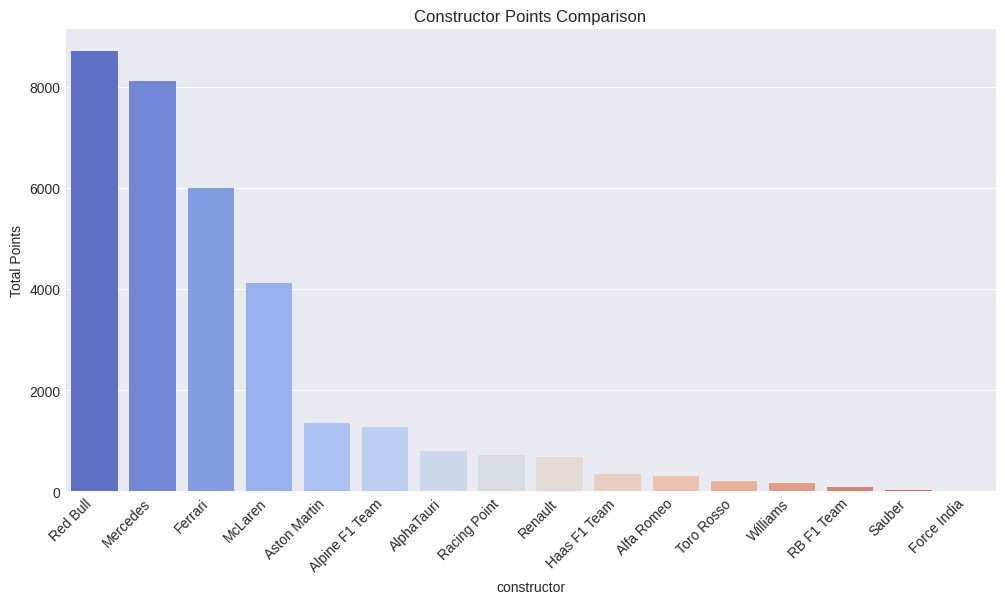

/tmp/ipython-input-1839593346.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=constructor_eval, x="constructor", y="avg_stint_length", palette="viridis")


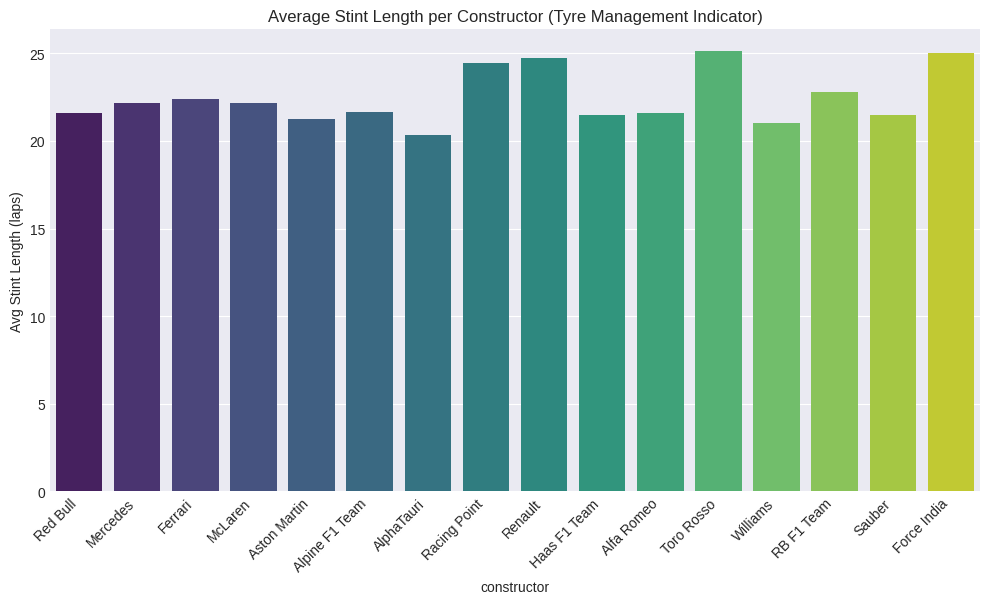

In [309]:
plt.figure(figsize=(12,6))
sns.barplot(data=constructor_eval, x="constructor", y="total_points", palette="coolwarm")
plt.title("Constructor Points Comparison")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total Points")
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=constructor_eval, x="constructor", y="avg_stint_length", palette="viridis")
plt.title("Average Stint Length per Constructor (Tyre Management Indicator)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Avg Stint Length (laps)")
plt.show()


Does the car’s pace increase during a stint, and how does this relate to tire compounds and tire degradation?


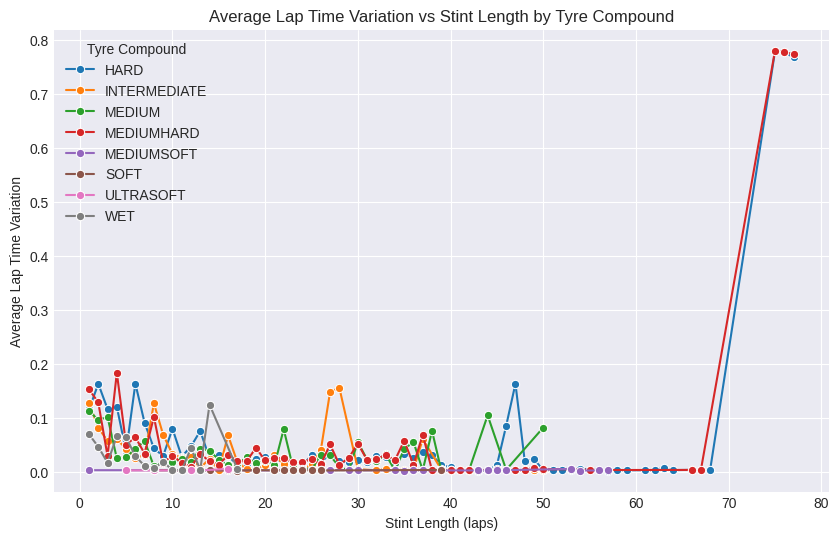

In [311]:


# Calculate average lap time variation per stint length per compound
stint_pace = (
    df.groupby(["compound", "stint_length"])['lap_time_variation']
    .mean()
    .reset_index()
    .rename(columns={'lap_time_variation': 'avg_lap_time_variation'}) # Rename for clarity in plot
)

plt.figure(figsize=(10,6))
sns.lineplot(data=stint_pace, x="stint_length", y="avg_lap_time_variation", hue="compound", marker="o")
plt.title("Average Lap Time Variation vs Stint Length by Tyre Compound")
plt.xlabel("Stint Length (laps)")
plt.ylabel("Average Lap Time Variation")
plt.legend(title="Tyre Compound")
plt.show()


Is the championship winner consistent every year or does it change?

In [312]:

# Aggregate total points per driver per season
driver_champions = (
    df.groupby(["season", "driver"])
    .agg(total_points=("points", "sum"))
    .reset_index()
)

# Find the top driver per season
driver_champions = driver_champions.loc[driver_champions.groupby("season")["total_points"].idxmax()]
driver_champions = driver_champions.sort_values("season")
driver_champions


season          driver  total_points
11     2018  Max Verstappen           111
29     2019  Lewis Hamilton           782
49     2020  Lewis Hamilton           933
68     2021  Lewis Hamilton          1028
90     2022  Max Verstappen          1061
114    2023  Max Verstappen          1544
138    2024  Max Verstappen          1021

In [313]:
# Aggregate total points per constructor per season
constructor_champions = (
    df.groupby(["season", "constructor"])
    .agg(total_points=("points", "sum"))
    .reset_index()
)

# Find the top constructor per season
constructor_champions = constructor_champions.loc[constructor_champions.groupby("season")["total_points"].idxmax()]
constructor_champions = constructor_champions.sort_values("season")
constructor_champions


season constructor  total_points
0     2018     Ferrari           158
14    2019    Mercedes          1435
25    2020    Mercedes          1501
37    2021    Mercedes          1609
48    2022    Red Bull          1816
58    2023    Red Bull          2251
64    2024     McLaren          1529

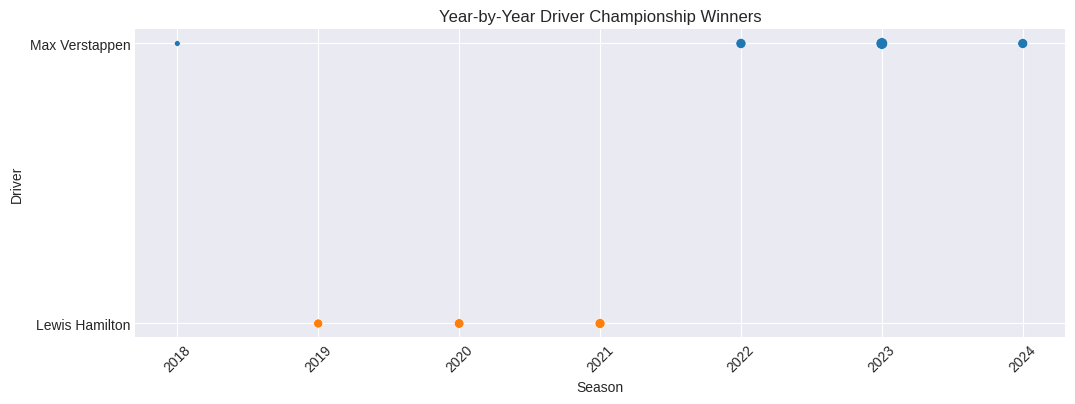

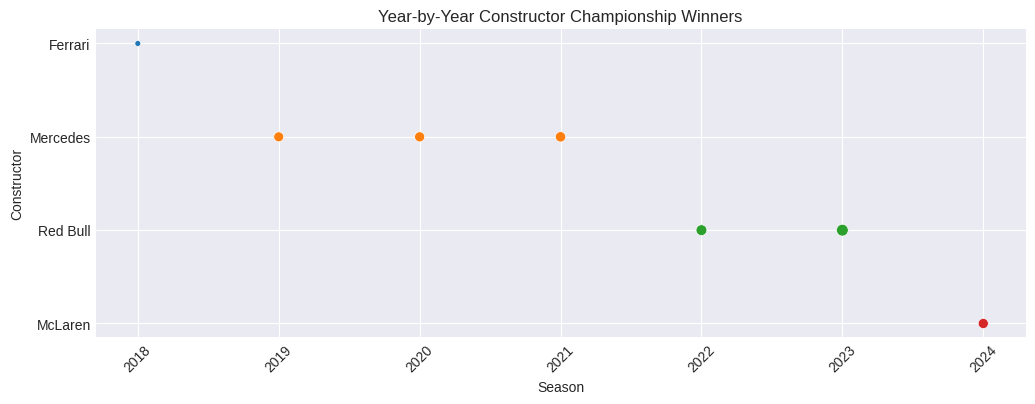

In [314]:

# Driver champions timeline
plt.figure(figsize=(12,4))
sns.scatterplot(data=driver_champions, x="season", y="driver", size="total_points", hue="driver", legend=False, s=200)
plt.title("Year-by-Year Driver Championship Winners")
plt.xlabel("Season")
plt.ylabel("Driver")
plt.xticks(rotation=45)
plt.show()

# Constructor champions timeline
plt.figure(figsize=(12,4))
sns.scatterplot(data=constructor_champions, x="season", y="constructor", size="total_points", hue="constructor", legend=False, s=200)
plt.title("Year-by-Year Constructor Championship Winners")
plt.xlabel("Season")
plt.ylabel("Constructor")
plt.xticks(rotation=45)
plt.show()


Deg Level

In [329]:
import pandas as pd
import numpy as np

# Ensure df is loaded and has the required columns, similar to previous processing
# This assumes df is loaded from 'F1_flat_final.xlsx' or a similar source
# If df is already modified by a preceding cell, these steps will re-apply/re-verify
# Renaming for consistency with the rest of the script
if 'tire_compound' in df.columns:
    df = df.rename(columns={'tire_compound': 'compound'})
if 'position' in df.columns:
    df = df.rename(columns={'position': 'race_position'})
if 'tire_usage_aggression' in df.columns:
    df = df.rename(columns={'tire_usage_aggression': 'tyre_usage_aggression'})

# Ensure necessary columns are numeric and handle NaNs for calculations
df['stint_length'] = pd.to_numeric(df['stint_length'], errors='coerce').fillna(0)
df['totalpitstops'] = pd.to_numeric(df['totalpitstops'], errors='coerce').fillna(0).astype(int)
df['driver_aggression_score'] = pd.to_numeric(df['driver_aggression_score'], errors='coerce')

# Handle driver aggression zeros / NaNs
if (df['driver_aggression_score'] == 0).any() or df['driver_aggression_score'].isna().any():
    drv_med = df.groupby('driver')['driver_aggression_score'].median()
    df['driver_aggression_score'] = df.apply(
        lambda r: drv_med[r['driver']] if (pd.isna(r['driver_aggression_score']) or r['driver_aggression_score']==0) else r['driver_aggression_score'],
        axis=1
    )
    df['driver_aggression_score'] = df['driver_aggression_score'].fillna(df['driver_aggression_score'].median())

# Calculate average stint length per track x compound
track_comp_avg = (
    df.groupby(['race_name','compound'])['stint_length']
    .mean()
    .reset_index()
    .rename(columns={'stint_length':'avg_stint_length'})
)
df = df.merge(track_comp_avg, on=['race_name','compound'], how='left')

# Calculate race average pitstops
race_avg_pits = df.groupby('race_name')['totalpitstops'].mean().rename('race_avg_pits').reset_index()
df = df.merge(race_avg_pits, on='race_name', how='left')
df['race_avg_pits'] = df['race_avg_pits'].replace(0, 1) # Prevent division by zero

# Compute adjusted stint proxies
df['adj_stint'] = df['avg_stint_length'] / df['driver_aggression_score']
df['adj2_stint'] = df['adj_stint'] / df['race_avg_pits']
df['adj2_stint'] = df['adj2_stint'].replace(0, np.nan).fillna(df['adj2_stint'].median())

# Compute deg_proxy
df['deg_proxy'] = 1.0 / df['adj2_stint']

# متوسط deg_proxy لكل تراك × كومباوند
track_comp_deg = df.groupby(['race_name','compound'])['deg_proxy'].mean().reset_index()
# تصنيف degeneration
q33, q66 = track_comp_deg['deg_proxy'].quantile([0.33,0.66])
def deg_label(x):
    if x <= q33: return 'Low'
    if x <= q66: return 'Mid'
    return 'High'
track_comp_deg['deg_level'] = track_comp_deg['deg_proxy'].apply(deg_label)

# أفضل كومباوند لكل تراك (أعلى avg stint/أقل deg_proxy)
best_comp = track_comp_deg.loc[track_comp_deg.groupby('race_name')['deg_proxy'].idxmin()]
track_summary = track_comp_deg.merge(best_comp[['race_name','compound']], on='race_name', suffixes=('','_best'))
track_summary[['race_name','compound','deg_level','compound_best']]


race_name    compound deg_level compound_best
0    70th Anniversary Grand Prix        HARD       Mid          HARD
1    70th Anniversary Grand Prix      MEDIUM       Mid          HARD
2    70th Anniversary Grand Prix  MEDIUMHARD       Mid          HARD
3           Abu Dhabi Grand Prix        HARD       Low          HARD
4           Abu Dhabi Grand Prix      MEDIUM       Mid          HARD
..                           ...         ...       ...           ...
124     United States Grand Prix        HARD       Low          HARD
125     United States Grand Prix      MEDIUM       Low          HARD
126     United States Grand Prix  MEDIUMHARD       Mid          HARD
127     United States Grand Prix  MEDIUMSOFT       Low          HARD
128     United States Grand Prix        SOFT       Low          HARD

[129 rows x 4 columns]

In [316]:
driver_summary = df.groupby(['driver','race_name','deg_level']).agg(
    avg_finish=('race_position','mean'),
    top5_rate=('race_position', lambda s: (s<=5).mean()),
    mean_adj2_stint=('adj2_stint','mean'),
    driver_aggression=('driver_aggression_score','mean'),
    tyre_usage=('tyre_usage_aggression','mean')
).reset_index()

# أفضل تراك لكل سائق على حسب suitability (مثلاً lowest avg_finish)
best_tracks = driver_summary.loc[driver_summary.groupby('driver')['avg_finish'].idxmin()]
best_tracks[['driver','race_name','deg_level','avg_finish','driver_aggression','tyre_usage']]

driver                    race_name deg_level  avg_finish  \
50       Alexander Albon            Tuscan Grand Prix      High         3.0   
86    Antonio Giovinazzi     Saudi Arabian Grand Prix      High         9.0   
96       Brendon Hartley     United States Grand Prix       Low         9.0   
132         Carlos Sainz       Mexico City Grand Prix      High         3.0   
180      Charles Leclerc           Italian Grand Prix      High         2.0   
226     Daniel Ricciardo             Eifel Grand Prix       Low         3.0   
282         Daniil Kvyat            German Grand Prix      High         3.0   
345         Esteban Ocon            Sakhir Grand Prix       Low         2.0   
372      Fernando Alonso             Dutch Grand Prix      High         3.6   
404     Franco Colapinto        Azerbaijan Grand Prix      High         8.0   
459       George Russell           Spanish Grand Prix       Low         4.0   
498          Guanyu Zhou             Qatar Grand Prix       Mid         8.5   
505          Jack Doohan         Abu Dhabi Grand Prix       Low        15.0   
542      Kevin Magnussen       Mexico City Grand Prix      High         7.0   
568       Kimi Raikkönen           Bahrain Grand Prix       Mid         7.0   
645         Lance Stroll            Sakhir Grand Prix       Low         3.0   
675         Lando Norris    Emilia Romagna Grand Prix       Low         2.0   
719       Lewis Hamilton           Belgian Grand Prix       Low         1.0   
771          Liam Lawson         Singapore Grand Prix       Low         9.0   
805       Logan Sargeant     United States Grand Prix       Low        10.0   
808      Marcus Ericsson           Mexican Grand Prix       Low         9.0   
811       Max Verstappen  70th Anniversary Grand Prix       Mid         1.0   
870      Mick Schumacher           Bahrain Grand Prix       Mid        11.0   
921      Nicholas Latifi          Japanese Grand Prix      High         9.0   
948      Nico Hülkenberg           British Grand Prix       Mid         6.0   
983       Nikita Mazepin        Azerbaijan Grand Prix      High        14.0   
1007       Nyck de Vries           Italian Grand Prix      High         9.0   
1016      Oliver Bearman     Saudi Arabian Grand Prix      High         7.0   
1027       Oscar Piastri           Belgian Grand Prix       Low         2.0   
1075        Pierre Gasly             Dutch Grand Prix      High         5.5   
1129     Romain Grosjean            German Grand Prix      High         7.0   
1170    Sebastian Vettel            German Grand Prix      High         2.0   
1240        Sergio Pérez            Sakhir Grand Prix       Low         1.0   
1267     Valtteri Bottas           Chinese Grand Prix       Low         2.0   
1326        Yuki Tsunoda         Hungarian Grand Prix      High         6.0   

      driver_aggression  tyre_usage  
50            74.393186    0.084746  
86           147.707784    0.040000  
96             6.485374    0.018182  
132           57.547440    0.023474  
180            6.477078    0.040431  
226            6.719061    0.033333  
282            6.789540    0.062500  
345            6.364410    0.011494  
372           42.813421    0.055575  
404            6.964443    0.019608  
459            6.495402    0.030303  
498            5.790276    0.052632  
505            6.772012    0.017544  
542            6.548861    0.014085  
568            6.243703    0.035088  
645            6.328285    0.011494  
675            5.534533    0.015873  
719            6.591616    0.037879  
771            5.206455    0.016129  
805            6.311661    0.035714  
808            5.347335    0.014493  
811            5.706153    0.038462  
870            6.296171    0.035088  
921           22.591184    0.071429  
948            5.609770    0.038462  
983           40.316117    0.117647  
1007           6.364241    0.018868  
1016           6.681207    0.020000  
1027           6.562814    0.045455  
1075          42.807794    0.0597


--- Highest DNF Conditions ---
Highest DNF Rate = 7.463%
Temperature Range = (20, 23]
Humidity Range = (80, 100]

--- Weather Index Impact ---
        index_bin  is_dnf_end_of_pit
0  (0.225, 0.433]           0.003165
1  (0.433, 0.572]           0.003534
2  (0.572, 0.613]           0.005093
3  (0.613, 0.651]           0.000000
4  (0.651, 0.666]           0.000000
5  (0.666, 0.681]           0.001689
6  (0.681, 0.705]           0.006757
7   (0.705, 0.72]           0.003373
8   (0.72, 0.749]           0.004823
9  (0.749, 0.882]           0.008913


/tmp/ipython-input-3546341320.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["temp_bin", "hum_bin"])["is_dnf_end_of_pit"].mean().reset_index()
/tmp/ipython-input-3546341320.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index_rate = df.groupby("index_bin")["is_dnf_end_of_pit"].mean().reset_index()


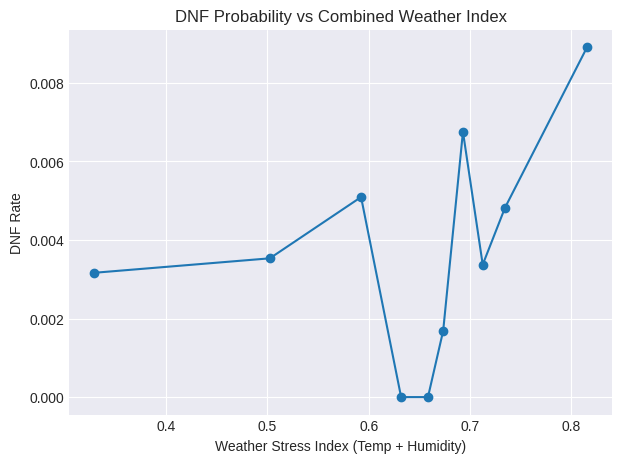

In [334]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1) Load & Prepare Data
# ------------------------------
df = pd.read_excel("F1_flat_final.xlsx").copy()
df["is_dnf_end_of_pit"] = df["is_dnf_end_of_pit"].astype(int)

# Fill missing values
df["air_temp_c"] = df["air_temp_c"].fillna(df["air_temp_c"].mean())
df["humidity_%"] = df["humidity_%"].fillna(df["humidity_%"].mean())

# ------------------------------
# 2) Create Weather Stress Index
# ------------------------------
df["temp_norm"] = (df["air_temp_c"] - df["air_temp_c"].min()) / (df["air_temp_c"].max() - df["air_temp_c"].min())
df["hum_norm"] = (df["humidity_%"] - df["humidity_%"].min()) / (df["humidity_%"].max() - df["humidity_%"].min())

df["weather_index"] = (df["temp_norm"] + df["hum_norm"]) / 2

# ------------------------------
# 3) Find the highest DNF conditions
# ------------------------------
# Create bins for temp & humidity
df["temp_bin"] = pd.cut(df["air_temp_c"], bins=[-10, 10, 15, 20, 23, 30, 50])
df["hum_bin"] = pd.cut(df["humidity_%"], bins=[0, 40, 60, 70, 80, 100])

grouped = df.groupby(["temp_bin", "hum_bin"])["is_dnf_end_of_pit"].mean().reset_index()
top = grouped.sort_values("is_dnf_end_of_pit", ascending=False).iloc[0]

print("\n--- Highest DNF Conditions ---")
print(f"Highest DNF Rate = {round(top['is_dnf_end_of_pit']*100,3)}%")
print(f"Temperature Range = {top['temp_bin']}")
print(f"Humidity Range = {top['hum_bin']}")

# ------------------------------
# 4) Find DNF vs Weather Index
# ------------------------------
df["index_bin"] = pd.qcut(df["weather_index"], q=10, duplicates='drop')
index_rate = df.groupby("index_bin")["is_dnf_end_of_pit"].mean().reset_index()

print("\n--- Weather Index Impact ---")
print(index_rate)

# ------------------------------
# 5) Final Visual (Weather Index vs DNF)
# ------------------------------
plt.figure(figsize=(7,5))
plt.plot(index_rate["index_bin"].apply(lambda b: b.mid), index_rate["is_dnf_end_of_pit"], marker='o')
plt.xlabel("Weather Stress Index (Temp + Humidity)")
plt.ylabel("DNF Rate")
plt.title("DNF Probability vs Combined Weather Index")
plt.grid(True)
plt.show()

